<a href="https://colab.research.google.com/github/biagio-incardona/biagio-incardona.github.io/blob/master/Report_Incardona_Biagio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Health Insurance Cross Sell Prediction Report</center>

![intro](https://gitlab.com/gerasia/temp/-/raw/master/new_intro.jpg)
<div style="text-align: right">  <b>MADE BY</b>: Incardona Biagio</div>
<div style="text-align: right">  <b>UNIVERSITY ID (MATRICOLA)</b>: 1000023753 </div>

## Context

Object to study of this report is the ***Health Insurance Cross Sell Prediction*** dataset, freely available on [Kaggle](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction?select=train.csv).

The dataset consists in a single *csv* file containing informations about some potential customers of an Healt Insurance company. 
The Insurance company has provided Health Insurance to its customers and now they need to identify if there are some   policyholders (customers) that will also be interested in Vehicle Insurance provided by the company.

## Content

The dataset has approximately 400.000 rows and 12 columns. These columns contains personal informations about potential customer like age, gender, region code, but also informations about his car (if the user has one) and his life as a driver (if the user can drive). Since the dataset is labeled it contains also a *Response* variable which tell us if the user has accepted the new contract or not. Sice we won't do a classification analysis, we can delete this column or use it just for validating the clusters we will find (if any).

## Disclaimer

Since our machine is really powerless, using the entire dataset for some operations will takes even more than 4 hours of computing (real test, not finished the computation) or even a crash of the system, we will apply a random sampling of the dataset in order to reduce the number of rows from about 400.000 to 5.000 units and we will do all the analysis and discussions on the reduced dataset.

I know that in this way we are losing a lot of important informations and there are a lot of probabilities that the row reduction operation will be an high negative bias on the analysis, but this was the only way to compute some operations in a reasonable time! For example it's impossible to compute a $400.000 \times 400.000$ distance matrix 

## Packages

The following code cell will be used to import all the packages needed to this report

In [1]:
# shut down all the warnings
options(warn = -1)

# install libraries
lib.names <- c("devtools","Hmisc", "mclust", "fpc", "data.table",
                "NbClust","corrplot","spgs", "factoextra", "ggridges",
                "tidyr", "clustertend", "vcd", "ltm","StatMatch",
                "gamlss", "gamlss.mx", "boot","ggfortify")

install.packages(lib.names)

# load libraries
library(ggplot2)
library(ggfortify)
library(boot)
library(dplyr)
library(gamlss)
library(gamlss.mx)
library(Hmisc)
library(data.table)
library(corrplot)
library(factoextra)
library(ggridges)
library(tidyr)
library(clustertend)
library(vcd)
library(ltm)
library(StatMatch)
library(cluster)
library(devtools)
library(fpc)
library(mclust)
install_github("biagio-incardona/myClValid")
library(myClValid)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘matrixStats’, ‘RcppArmadillo’, ‘SparseM’, ‘MatrixModels’, ‘conquer’, ‘sp’, ‘openxlsx’, ‘nloptr’, ‘statmod’, ‘RcppEigen’, ‘carData’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’, ‘png’, ‘jpeg’, ‘checkmate’, ‘modeltools’, ‘DEoptimR’, ‘car’, ‘ellipse’, ‘flashClust’, ‘leaps’, ‘scatterplot3d’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘polynom’, ‘rstatix’, ‘zoo’, ‘mvtnorm’, ‘expm’, ‘minqa’, ‘numDeriv’, ‘mitools’, ‘Formula’, ‘latticeExtra’, ‘gridExtra’, ‘htmlTable’, ‘viridis’, ‘flexmix’, ‘prabclus’, ‘diptest’, ‘robustbase’, ‘kernlab’, ‘abind’, ‘dendextend’, ‘FactoMineR’, ‘ggpubr’, ‘reshape2’, ‘ggrepel’, ‘plyr’, ‘lmtest’, ‘msm’, ‘polycor’, ‘proxy’, ‘survey’, ‘lpSolve’, ‘gamlss.data’, ‘gamlss.dist’



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, se

mltools (NA -> 0.3.5) [CRAN]


Installing 1 packages: mltools

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/Rtmp9rBMJ1/remotes376ecbbdc5/biagio-incardona-myClValid-359656c/DESCRIPTION’
─  preparing ‘myClValid’:
✔  checking DESCRIPTION meta-information
✔  checking vignette meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘myClValid_0.1.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: mltools


Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na




## 1. Preliminar analysis and data cleaning

Let's start importing the file into the system.

In [2]:
# Loading the dataset into the 'insurance.data' variable
insurance.data <- read.csv('Healt_Insurance.csv')

First of all let's define some useful functions for univariate analysis

In [3]:
# generate distribution of the following families
# GA, BE, EXP, IGAMMA, IG, JSU, GG, GU, LO, LOGNO, WEI
getDens <- function(seqs, family,  i, mu.hats, sigma.hats = NULL, nu.hats = NULL, tau.hats = NULL){
  dens <- NULL
  switch(family,
    GA = {
      dens <- dGA(seqs, mu = mu.hats[i], sigma = sigma.hats[i])
    },
    BE = {
      dens <- dBE(seqs, mu = mu.hats[i], sigma = sigma.hats[i])
    },
    EXP = {
      dens <- dEXP(seqs, mu=mu.hats[i])
    },
    IGAMMA ={
      dens <- dIGAMMA(seqs, mu=mu.hats[i], sigma = sigma.hats[i])
    },
    IG = {
      dens <- dIG(seqs, mu=mu.hats[i], sigma = sigma.hats[i])
    },
    JSU = {
      dens <- dJSU(seqs, mu = mu.hats[i], sigma = sigma.hats[i], 
                   nu = nu.hats[i], tau = tau.hats[i])
    },
    GG = {
      dens <- dGG(seqs, mu=mu.hats[i], sigma = sigma.hats[i], nu = nu.hats[i])
    },
    GU = {
      dens <- dGU(seqs, mu=mu.hats[i], sigma = sigma.hats[i])
    },
    LO = {
      dens <- dLO(seqs, mu = mu.hats[i], sigma = sigma.hats[i])
    },
    LOGNO = {
      dens <- dLOGNO(seqs, mu = mu.hats[i], sigma = sigma.hats[i])
    },
    WEI = {
      dens <- dWEI(seqs, mu = mu.hats[i], sigma = sigma.hats[i])
    })
  return(dens)
}

# plot gamlss.mx for any number of distributions with family in:
# GA, BE, EXP, IGAMMA, IG, JSU, GG, GU, LO, LOGNO, WEI
plot.gamlss <- function(var, family, fit, K, mu.hats, sigma.hats = NULL, nu.hats = NULL, tau.hats = NULL){
  hist(var, breaks = 70, freq = F, main = paste("histogram of: ", family))
  seqs <- seq(min(var),max(var),length=length(var))
  for(i in 1:K){
    dens <- getDens(seqs, family, i, mu.hats, sigma.hats, nu.hats, tau.hats)
    lines(seqs, fit[["prob"]][i] * dens, lty=2, lwd=3, col=i+1)
  }
  dens <- getDens(seqs, family, 1, mu.hats, sigma.hats, nu.hats, tau.hats)
  all <- fit[["prob"]][1] * dens

  for(i in 2:K){
    dens <- getDens(seqs, family, i, mu.hats, sigma.hats, nu.hats, tau.hats)
    all <- all + fit[["prob"]][i] * dens
  }
  lines(seqs, all, lty = 1, lwd = 3, col = 1)
}

# get mu from any mixed gamlss of any family
get.mu.hats <- function(fit, K){
  mu.hats <- c()
  for(i in 1:K){
    switch(fit[["models"]][[i]][["mu.link"]],
      
      log = mu.hats[i] <- exp(fit[["models"]][[i]][["mu.coefficients"]]),
      
      logit = mu.hats[i] <- inv.logit(fit[["models"]][[i]][["mu.coefficients"]]),
      
      identity = mu.hats[i] <- fit[["models"]][[i]][["mu.coefficients"]]
    )
  }
  return(mu.hats)
}

# get sigma from any mixed gamlss of any family
get.sigma.hats <- function(fit, K){
  sigma.hats <- c()
  for(i in 1:K){
    switch(fit[["models"]][[i]][["sigma.link"]],

      log = sigma.hats[i] <- exp(fit[["models"]][[i]][["sigma.coefficients"]]),
    
      logit = sigma.hats[i] <- inv.logit(fit[["models"]][[i]][["sigma.coefficients"]]),
    
      identity = sigma.hats[i] <- fit[["models"]][[i]][["sigma.coefficients"]]
    )
  }
  return(sigma.hats)
}

# get nu from any mixed gamlss of any family
get.nu.hats <- function(fit, K){
  nu.hats <- c()
  for(i in 1:K){
    switch(fit[["models"]][[i]][["nu.link"]],
    
      log = nu.hats[i] <- exp(fit[["models"]][[i]][["nu.coefficients"]]),

      logit = nu.hats[i] <- inv.logit(fit[["models"]][[i]][["nu.coefficients"]]),

      identity = nu.hats[i] <- fit[["models"]][[i]][["nu.coefficients"]]
    )
  }
  return(nu.hats)
}

# get tau from any mixed gamlss of any family
get.tau.hats <- function(fit, K){
  tau.hats <- c()
  for(i in 1:K){
    switch(fit[["models"]][[i]][["tau.link"]],
      log = tau.hats[i] <- exp(fit[["models"]][[i]][["tau.coefficients"]]),

      logit = tau.hats[i] <- inv.logit(fit[["models"]][[i]][["tau.coefficients"]]),

      identity = tau.hats[i] <- fit[["models"]][[i]][["tau.coefficients"]]
    )
  }
  return(tau.hats)
}

showBest <- function(df){
  max.AIC <- rownames(df[which.max(df$AIC),])
  max.logLik <- rownames(df[which.max(df$logLik),])
  if (max.AIC == max.logLik){
    print(paste("best family according the majority rule:", df[max.AIC,1]))
  }
  else{
    print(paste("best family for AIC: ", max.AIC))
    print(paste("best family for logLikelihood: ", max.logLik))
    print("best families according to AIC")
    print(head(df %>% arrange(desc(AIC))))

    print("best families according to logLik")
    print(head(df %>% arrange(desc(logLik))))
  }
  
}

# test 10 gamlss.mx different families
test.all.gamlss.mx <- function(var, k){

  families <- c()
  AICs <- c()
  logLiks <- c()

  tryCatch(expr = {
    fit.GA <- gamlssMXfits(n=1,var~1, family=GA, K=k, data = NULL)
    families <- append(families, "GA")
    AICs <- append(AICs, -AIC(fit.GA))
    logLiks <- append(logLiks, logLik(fit.GA))
  }, error = function(e){
    print("Error in GA, passing over...")
  })

  tryCatch(expr = {
    fit.GU <- gamlssMXfits(n=1,var~1, family=GU, K=k, data = NULL)
    families <- append(families, "GU")
    AICs <- append(AICs, -AIC(fit.GU))
    logLiks <- append(logLiks, logLik(fit.GU))
  }, error = function(e){
    print("Error in GU, passing over...")
  })

  tryCatch(expr = {
    fit.EXP <- gamlssMXfits(n=1,var~1, family=EXP, K=k, data = NULL)
    families <- append(families, "EXP")
    AICs <- append(AICs, -AIC(fit.EXP))
    logLiks <- append(logLiks, logLik(fit.EXP))
  }, error = function(e){
    print("Error in EXP, passing over...")
  })

  tryCatch(expr = {
    fit.IGAMMA <- gamlssMXfits(n=1,var~1, family=IGAMMA, K=k, data = NULL)
    families <- append(families, "IGAMMA")
    AICs <- append(AICs, -AIC(fit.IGAMMA))
    logLiks <- append(logLiks, logLik(fit.IGAMMA))
  }, error = function(e){
    print("Error in IGAMMA, passing over...")
  })

  tryCatch(expr = {
    fit.IG <- gamlssMXfits(n=1,var~1, family=IG, K=k, data = NULL)
    families <- append(families, "IG")
    AICs <- append(AICs, -AIC(fit.IG))
    logLiks <- append(logLiks, logLik(fit.IG))
  }, error = function(e){
    print("Error in IG, passing over...")
  })

  tryCatch(expr = {
    fit.JSU <- gamlssMXfits(n=1,var~1, family=JSU, K=k, data = NULL)
    families <- append(families, "JSU")
    AICs <- append(AICs, -AIC(fit.JSU))
    logLiks <- append(logLiks, logLik(fit.JSU))
  }, error = function(e){
    print("Error in JSU, passing over...")
  })

  tryCatch(expr = {
    fit.GG <- gamlssMXfits(n=1,var~1, family=GG, K=k, data = NULL)
    families <- append(families, "GG")
    AICs <- append(AICs, -AIC(fit.GG))
    logLiks <- append(logLiks, logLik(fit.GG))
  }, error = function(e){
    print("Error in GG, passing over...")
  })

  tryCatch(expr = {
    fit.LO <- gamlssMXfits(n=1,var~1, family=LO, K=k, data = NULL)
    families <- append(families, "LO")
    AICs <- append(AICs, -AIC(fit.LO))
    logLiks <- append(logLiks, logLik(fit.LO))
  }, error = function(e){
    print("Error in LO, passing over...")
  })

  tryCatch(expr = {
    fit.LOGNO <- gamlssMXfits(n=1,var~1, family=LOGNO, K=k, data = NULL)
    families <- append(families, "LOGNO")
    AICs <- append(AICs, -AIC(fit.LOGNO))
    logLiks <- append(logLiks, logLik(fit.LOGNO))
  }, error = function(e){
    print("Error in LOGNO, passing over...")
  })

  tryCatch(expr = {
    fit.WEI <- gamlssMXfits(n=1,var~1, family=WEI, K=k, data = NULL)
    families <- append(families, "WEI")
    AICs <- append(AICs, -AIC(fit.WEI))
    logLiks <- append(logLiks, logLik(fit.WEI))
  }, error = function(e){
    print("Error in WEI, passing over...")
  })
  

  results <- data.frame(family = families, AIC = AICs, logLik = logLiks)
  showBest(results)
  return(results)

}

In [4]:
#n1 <- 200
#n2 <- 300
#n  <- n1 + n2
#X1 <- rJSU(n1, 0.001, 0.1, 0.14, 0.7)
#X2 <- rJSU(n2, 0.8, 0.04, 1, 3)
#XX <- c(X1,X2)

#fit <- gamlssMXfits(n = 1, XX~1, family = JSU, K = 2, data = NULL)
#mu <- get.mu.hats(fit, 2)
#sigma <- get.sigma.hats(fit, 2)
#nu <- get.nu.hats(fit, 2)
#tau <- get.tau.hats(fit,2)
#plot.gamlss(var = XX, family = "JSU", fit = fit, K = 2, mu.hats = mu, sigma.hats = sigma, nu.hats = nu, tau.hats = tau)

First of all we will get a random sampled version of the dataset

In [5]:
set.seed(12999)

rows <- sample(1:nrow(insurance.data), 5000)

insurance.data <- insurance.data[rows,]

Let's show the table.

In [6]:
head(insurance.data)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
,<int>,<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>
378435,378435,Male,31,1,11,0,< 1 Year,Yes,43273,124,136,1
115685,115685,Female,21,1,47,0,< 1 Year,Yes,33473,160,258,0
365317,365317,Male,54,1,50,1,1-2 Year,No,49929,8,68,0
224406,224406,Female,23,1,23,1,< 1 Year,No,2630,160,280,0
347561,347561,Male,21,1,22,1,< 1 Year,No,26989,152,62,0
181036,181036,Male,24,1,41,1,< 1 Year,No,43413,152,204,0


Now let's see if there are missing values

In [7]:
# for each value check if is missing or not
df.na <- is.na(insurance.data)

# for each column check how many missing values are there
apply(df.na, 2, sum)

id               Gender                  Age 
                   0                    0                    0 
     Driving_License          Region_Code   Previously_Insured 
                   0                    0                    0 
         Vehicle_Age       Vehicle_Damage       Annual_Premium 
                   0                    0                    0 
Policy_Sales_Channel              Vintage             Response 
                   0                    0                    0

Fortunately the dataset has not any missing values, so we can go on with our analysis without any fear.

Initially we will analyze and discuss the dataset structure.

In [8]:
str(insurance.data)

'data.frame':	5000 obs. of  12 variables:
 $ id                  : int  378435 115685 365317 224406 347561 181036 367664 278096 169180 208501 ...
 $ Gender              : chr  "Male" "Female" "Male" "Female" ...
 $ Age                 : int  31 21 54 23 21 24 65 23 23 46 ...
 $ Driving_License     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Region_Code         : num  11 47 50 23 22 41 10 14 11 29 ...
 $ Previously_Insured  : int  0 0 1 1 1 1 0 0 1 0 ...
 $ Vehicle_Age         : chr  "< 1 Year" "< 1 Year" "1-2 Year" "< 1 Year" ...
 $ Vehicle_Damage      : chr  "Yes" "Yes" "No" "No" ...
 $ Annual_Premium      : num  43273 33473 49929 2630 26989 ...
 $ Policy_Sales_Channel: num  124 160 8 160 152 152 124 152 152 124 ...
 $ Vintage             : int  136 258 68 280 62 204 294 76 265 47 ...
 $ Response            : int  1 0 0 0 0 0 0 0 0 0 ...


This dataset contains $n = 5000$ observations and $d = 12$ columns. Let's understand something about the variables:

### 1.1 ID

In [9]:
str(insurance.data$id)

 int [1:5000] 378435 115685 365317 224406 347561 181036 367664 278096 169180 208501 ...


It contains the identification number of each row and seems to be a 'row number count' variable with no particular informations.

In [10]:
# loading the rownames as integer into the 'indexs' variable
indexs <- as.integer(rownames(insurance.data))

# loading the id column into the 'ids' variable
ids <- insurance.data$id

# checking if the two vectors are equal
min(indexs == ids) == TRUE

[1] TRUE

Since the 'id' column is exactly a 'row number count' variable whe can delete it without losing informations 

In [11]:
insurance.data$id <- NULL

according to the reducted dimension of the dataset we will set the rownames as the vector  $[1,...,nrow(dataset)]$

In [12]:
rownames(insurance.data) <- 1:nrow(insurance.data)

### 1.2. Gender

In [64]:
str(insurance.data$Gender)

table(insurance.data$Gender)

 Factor w/ 2 levels "Female","Male": 2 1 2 1 2 2 2 1 1 1 ...



Female   Male 
  2332   2668 

This is a categorical variable, containing informations about the gender of a potential customer.

We will transform it in a factor variable with 2 levels: "Female" and "Male".

In [14]:
insurance.data$Gender <- as.factor(insurance.data$Gender)

In [58]:
print(head(insurance.data$Gender))

[1] Male   Female Male   Female Male   Male  
Levels: Female Male


Female   Male 
  2332   2668

Let's see how the two genders are distributed into the dataset

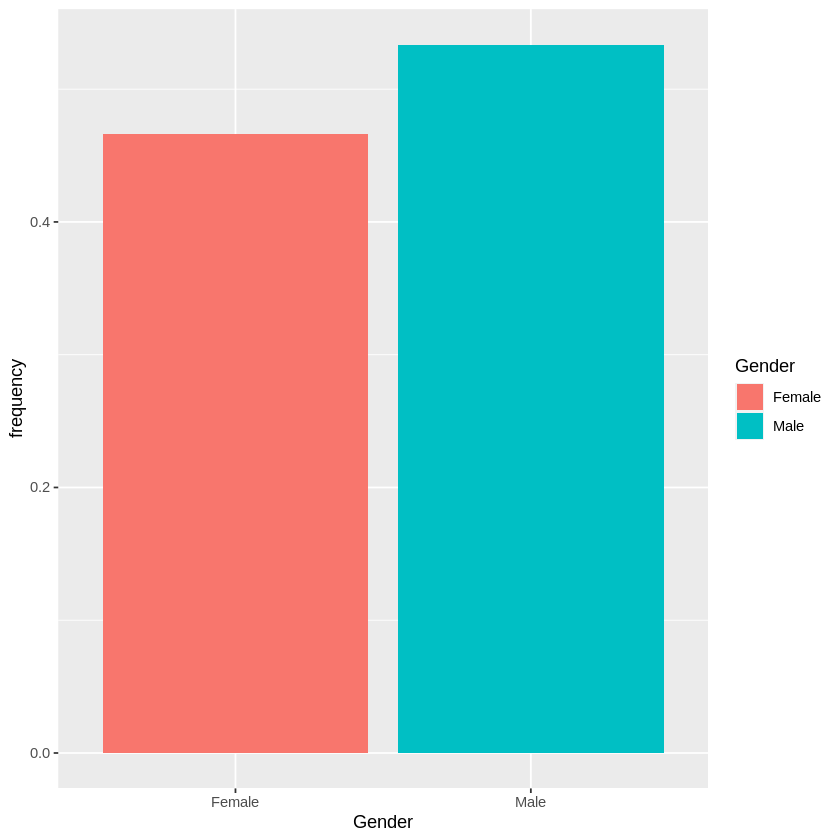

In [16]:
insurance.data %>%
    ggplot(aes(x = Gender, fill = Gender)) +
    geom_bar(aes(y = (..count..)/sum(..count..))) +
    ylab('frequency')

As we can see thanks to the bar plot the two genders are pretty equally distributed into the dataset, since the **Females** are approximately the $45\%$ of the data and the **Males** are approximately the $55\%$ of the data.

### 1.3. Age

In [59]:
str(insurance.data$Age)

summary(insurance.data$Age)

 int [1:5000] 31 21 54 23 21 24 65 23 23 46 ...


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  20.00   24.00   36.00   38.69   49.00   85.00 

This is an integer variable containing the potential customer's age.
This could be an important information since the higher the age is the more the risks are and the insurance premium could become higher, but the thing is also true in reverse, as younger people are less experienced and generally more reckless.

Let's see how this important variable is distributed

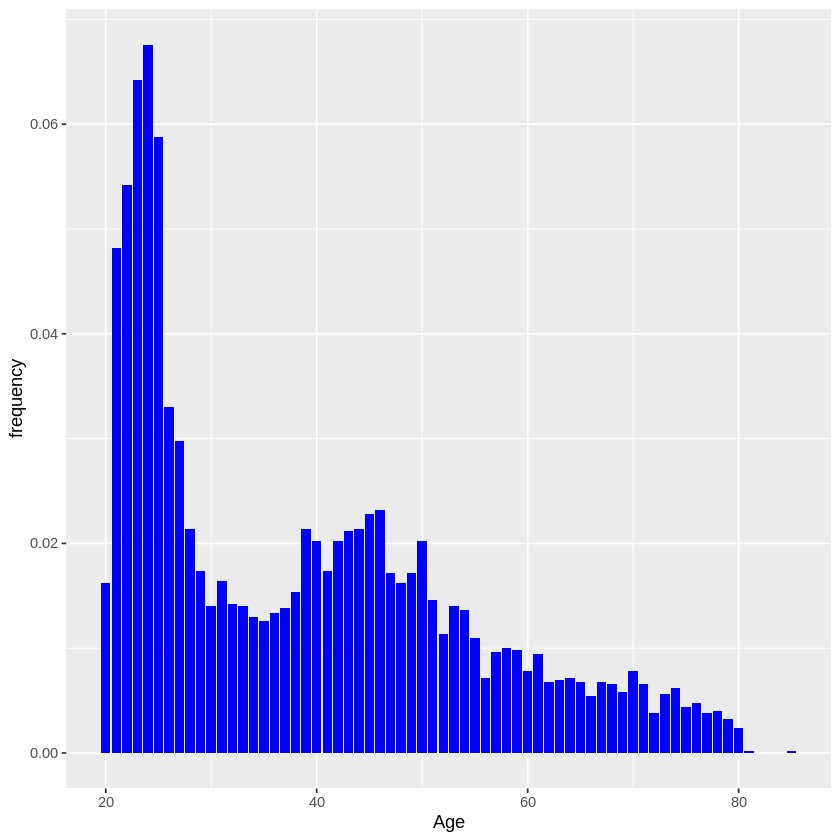

In [18]:
insurance.data %>%
    ggplot(aes(x = Age)) +
    geom_bar(aes(y = (..count..)/sum(..count..)), fill = "blue") +
    ylab("frequency")

It's interesting to see that the main part of the potential customers is between $20$ and $30$ years-old, it could mean that they are looking for their first insurance contract, so, since they are freshman they could be convinced easilier to sign with the company.

We can also see another peak in the plot, at the age interval $40-50$. This may be due to people having earned a fair amount of money and being looking for a better insurance contract.

Now we will try to fit some models to our variable.
First of all we will analyze and plot three of these models then we will test an higher number of families and pick up the best one.


model= 1 


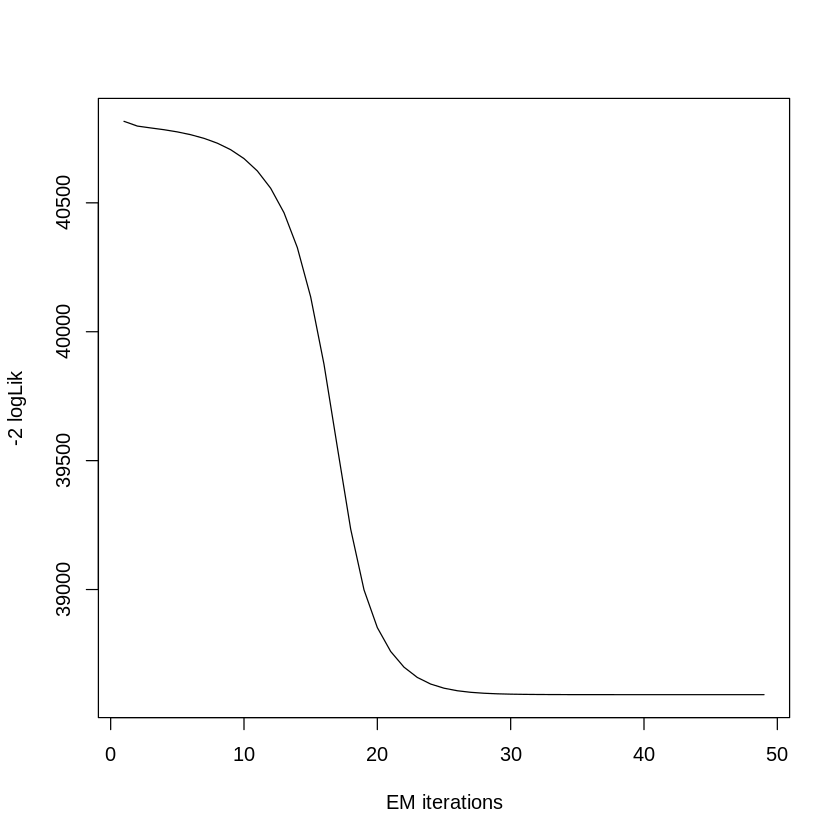

model= 2 


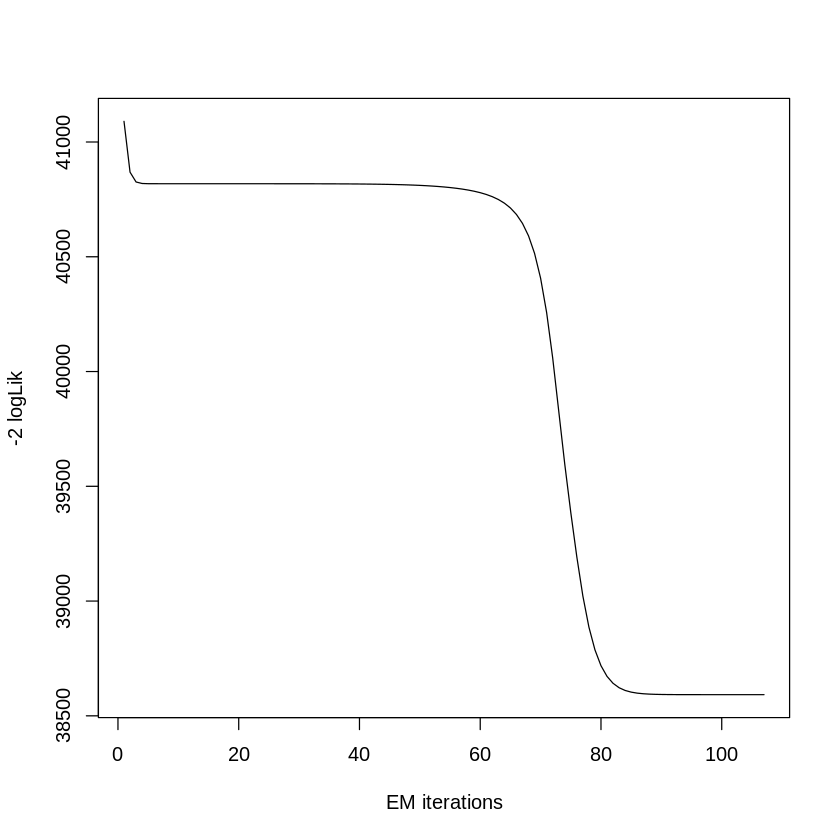

model= 3 


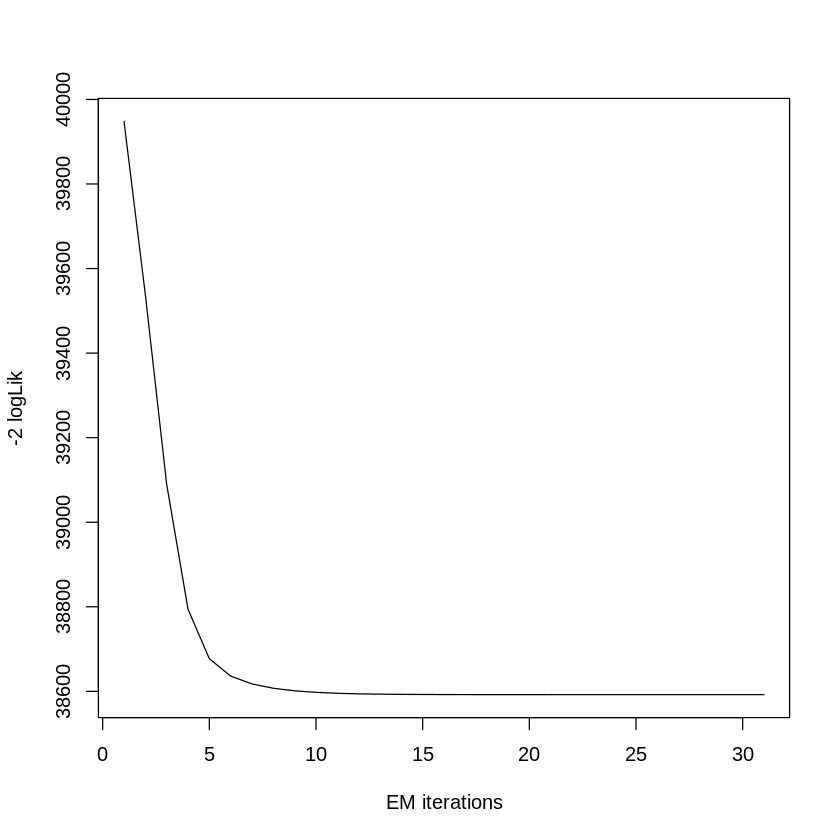

model= 4 


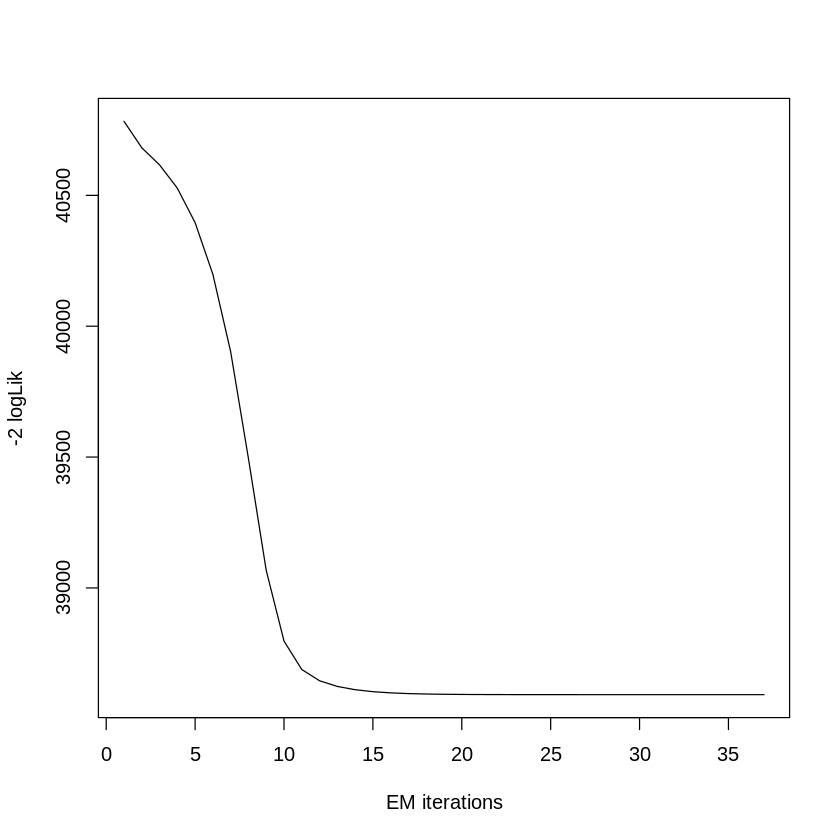

model= 5 


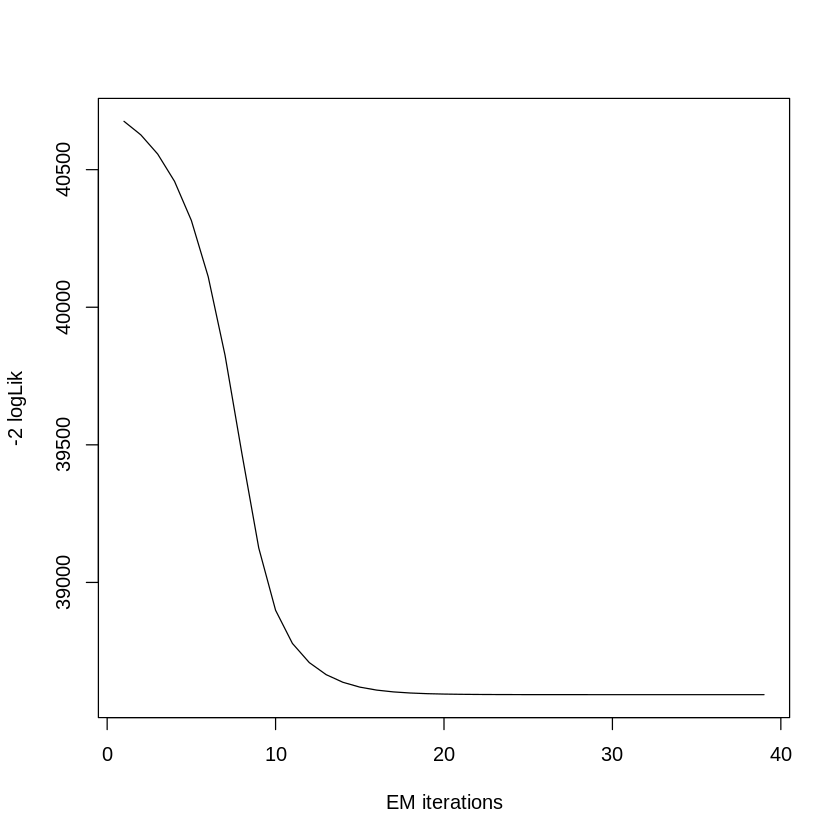

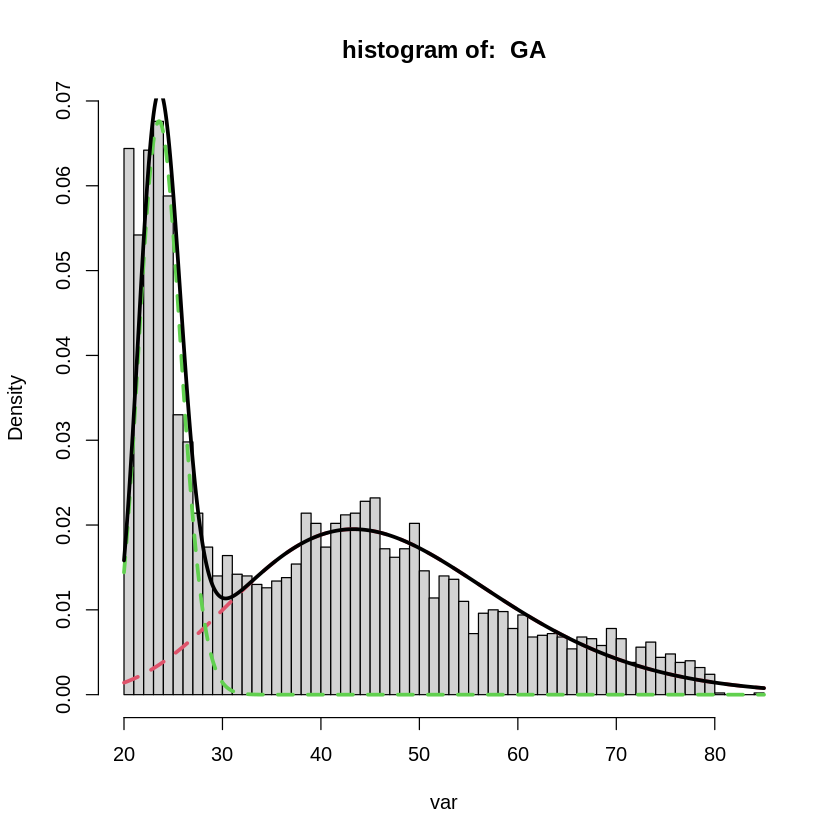

In [19]:
#c(GA, BE, EXP, IGAMMA, IG, JSU, GG, GU, LO, LOGNO, WEI)
fit.GA <- gamlssMXfits(n=5,Age~1,data = insurance.data, family=GA, K=2)

mu <- get.mu.hats(fit.GA, 2)
sigma <- get.sigma.hats(fit.GA, 2)

plot.gamlss(insurance.data$Age, "GA", fit.GA, 2, mu, sigma)

Using two gamma models seems to be a very nice choice in fitting our data, the sum of the two distributions follow the original variable in a pretty nice way.

model= 1 


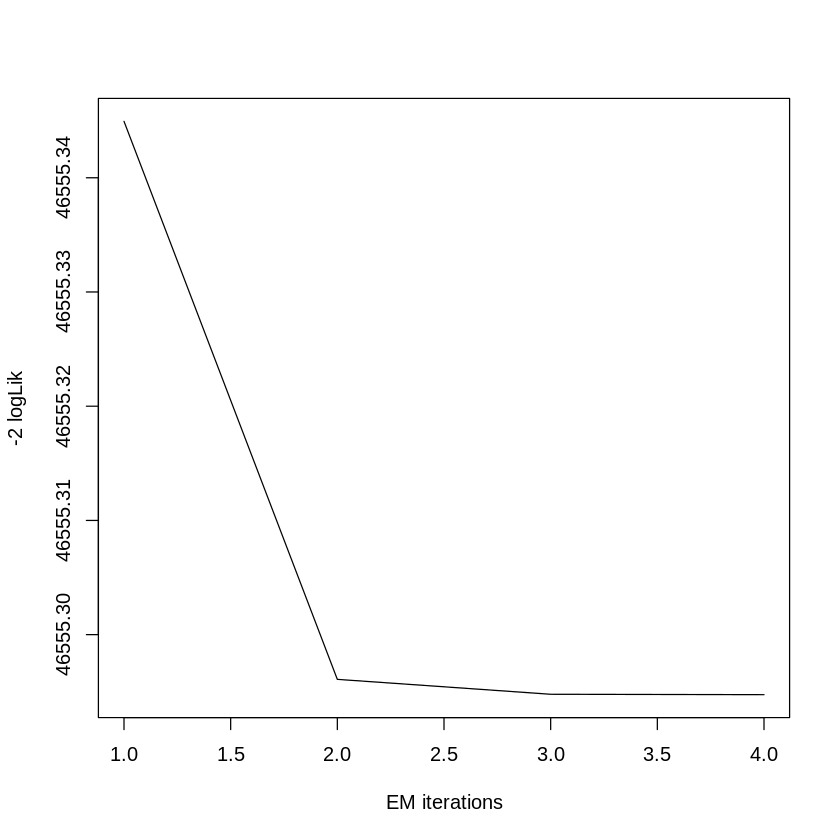

model= 2 


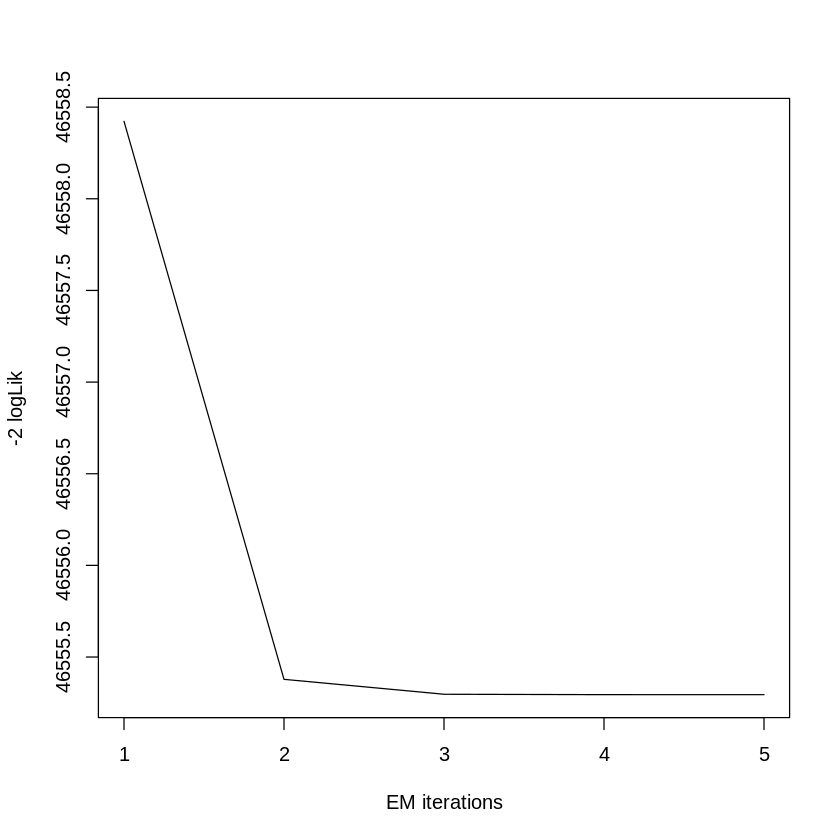

model= 3 


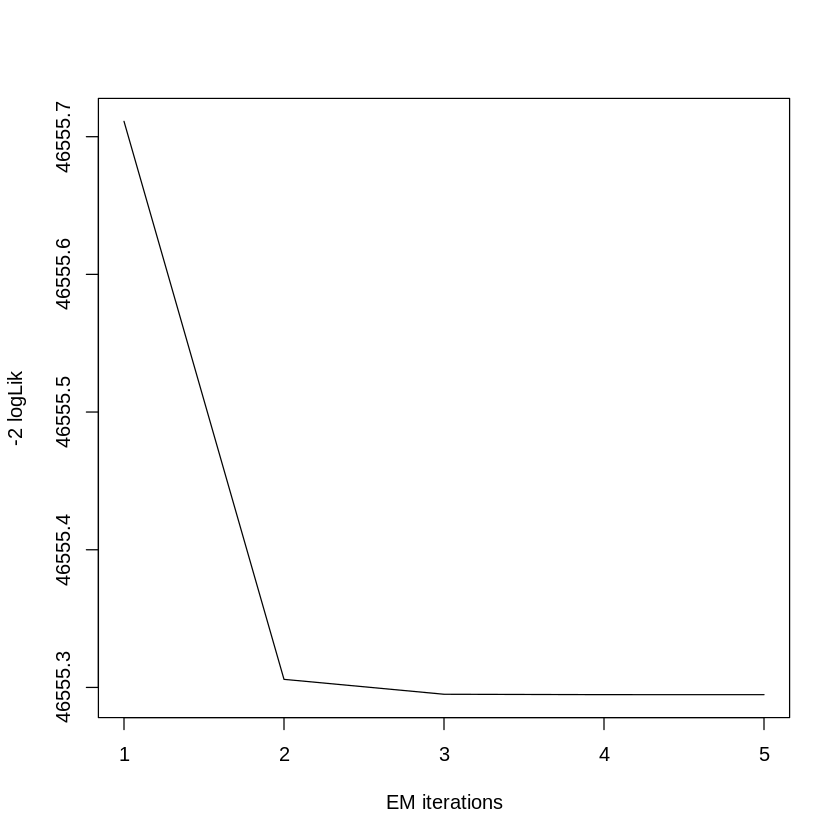

model= 4 


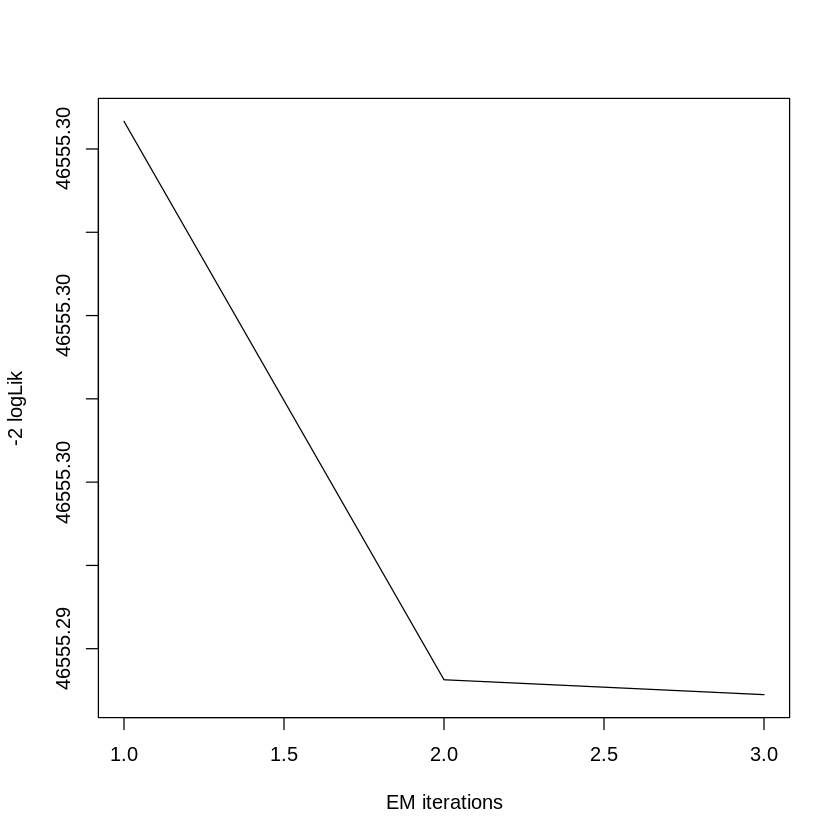

model= 5 


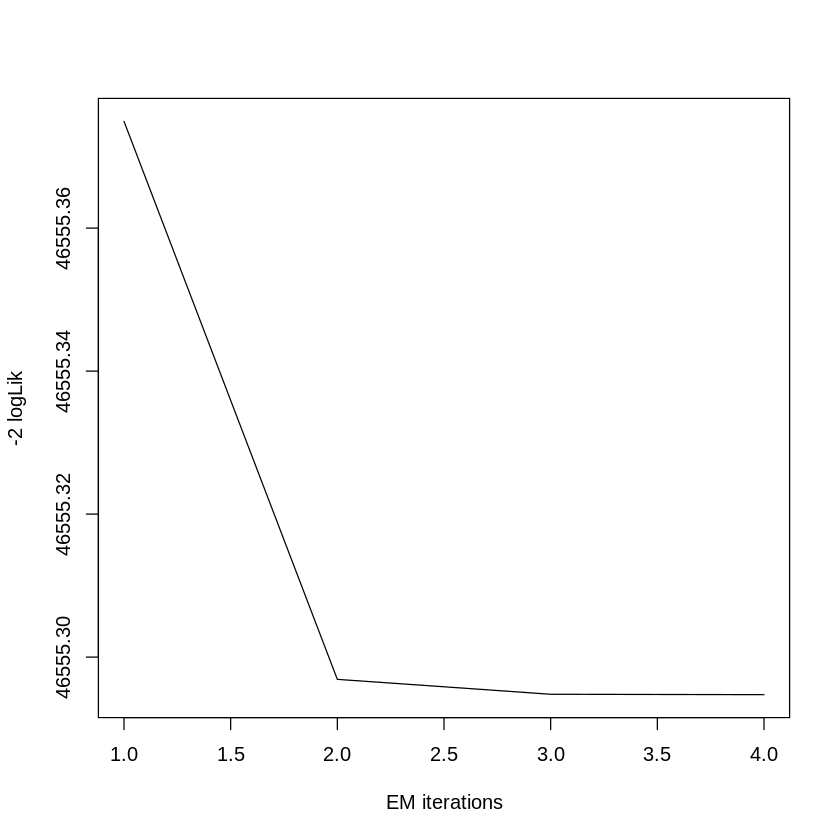

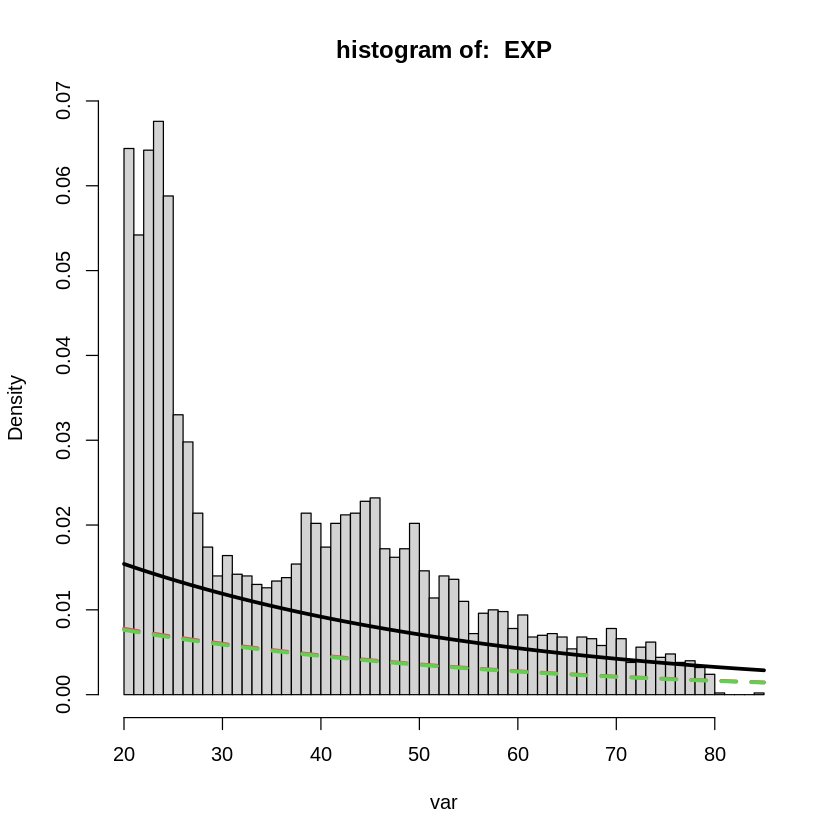

In [20]:
fit.EXP <- gamlssMXfits(n=5,Age~1,data = insurance.data, family=EXP, K=2)

mu <- get.mu.hats(fit.EXP, 2)

plot.gamlss(insurance.data$Age, "EXP", fit.EXP, 2, mu)

As we can see using two exponential distribution to fit our data was a really bad idea, but we could have expected so since the behaviour of the exponential distribution is very different from ours.

Now we will plot the last distribution family befor applying an automated function to compare $11$ different distribution families and taking the best one according to the majority rule testing **AIC** and **LogLikelihood** 

model= 1 


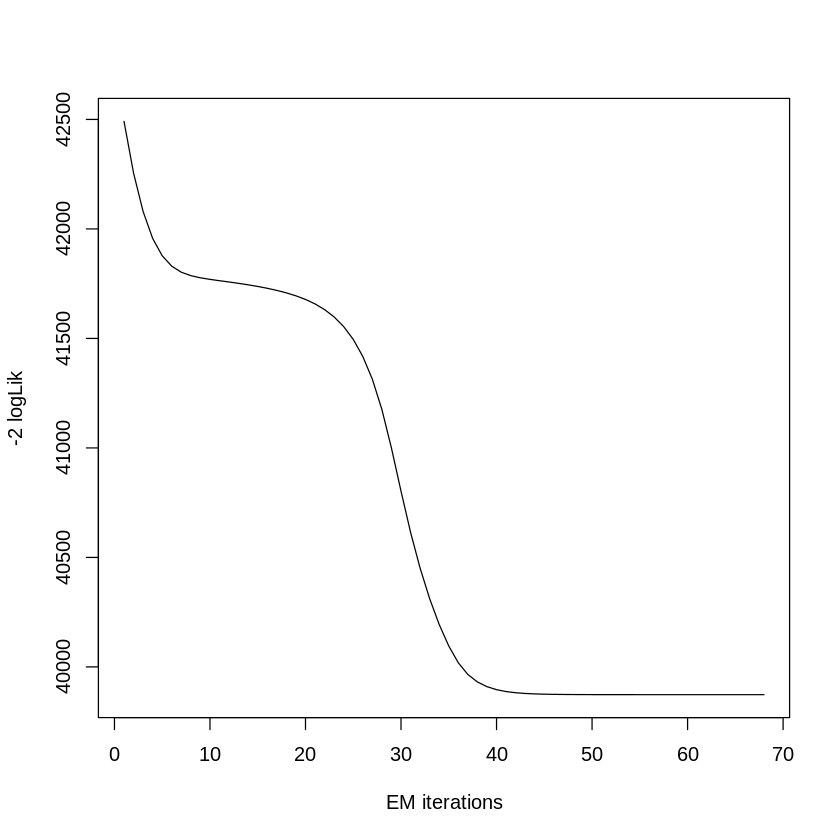

model= 2 


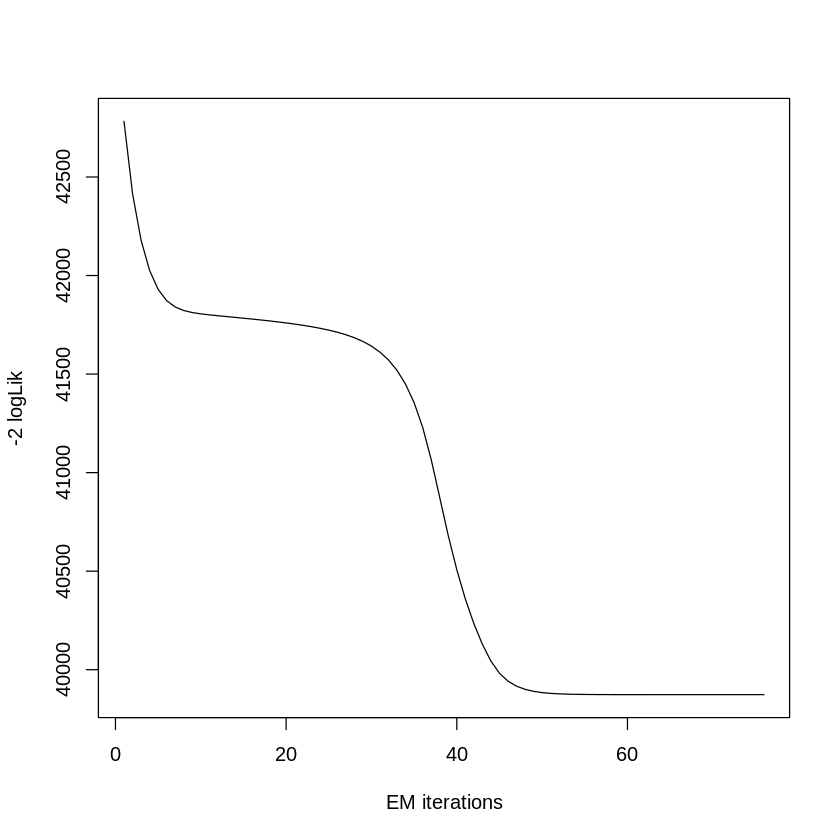

model= 3 


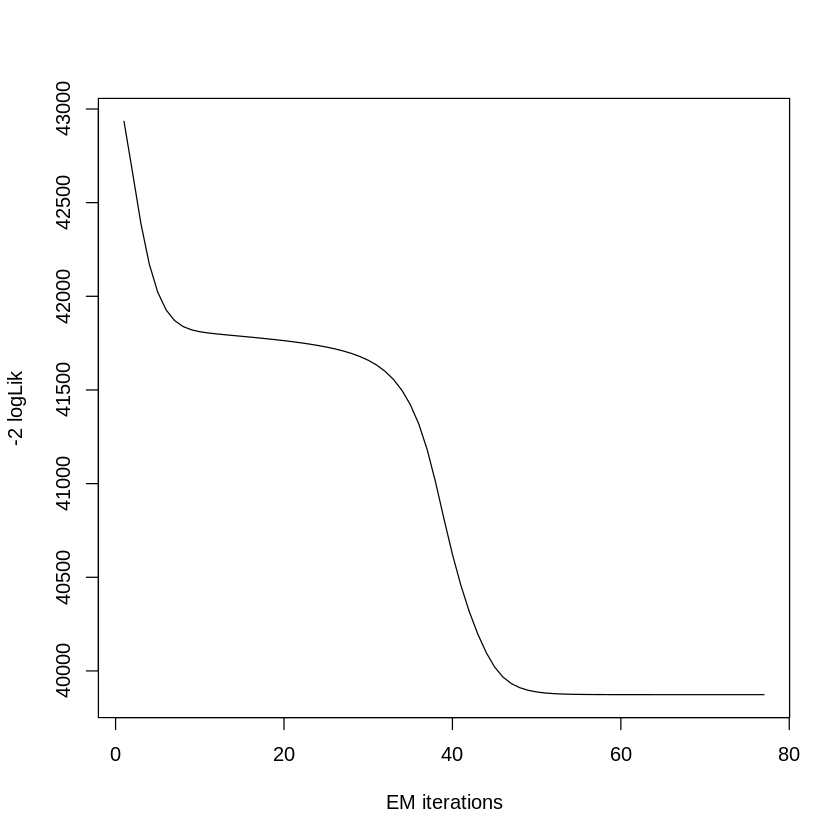

model= 4 


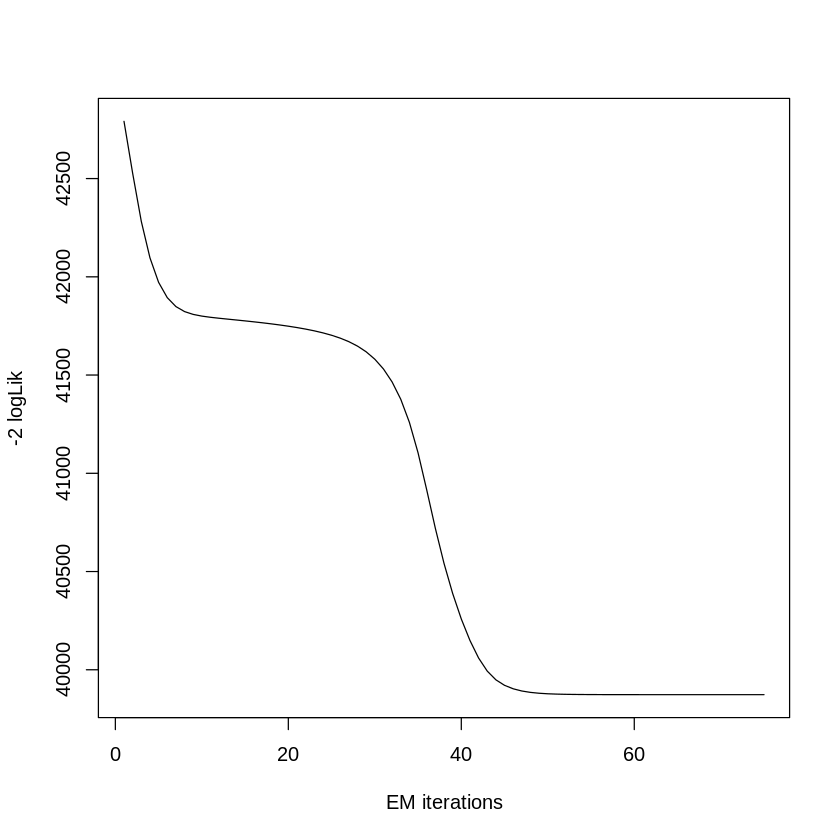

model= 5 


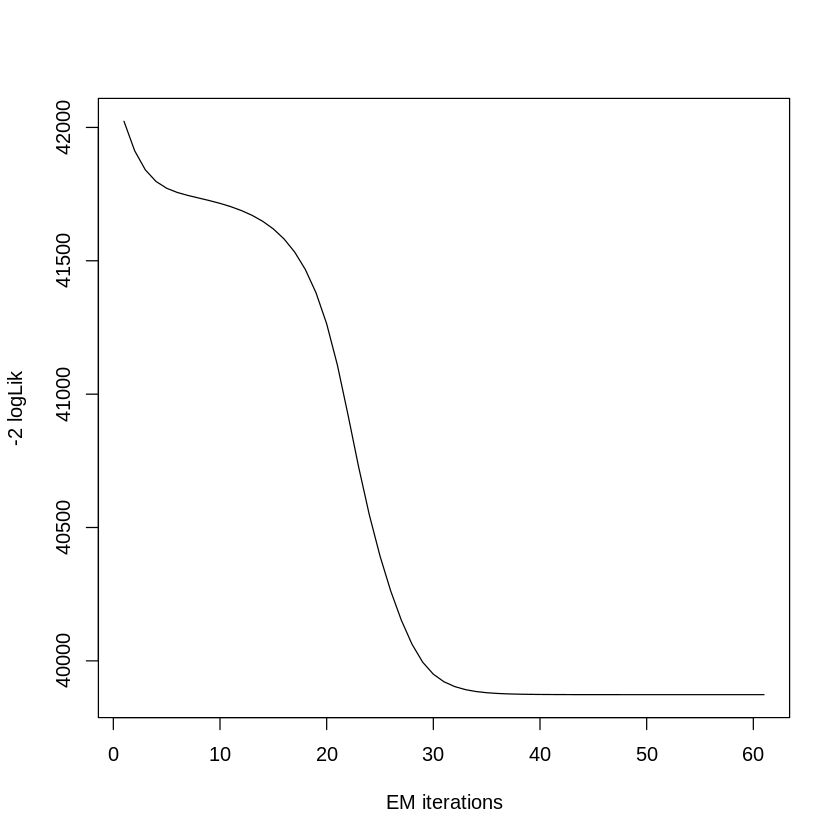

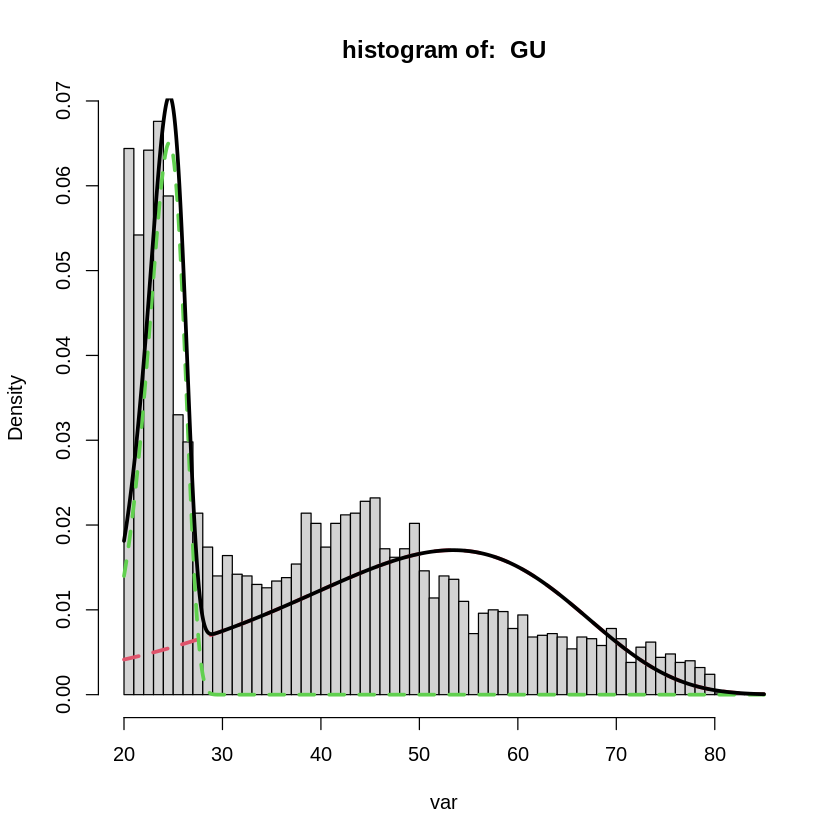

In [21]:
fit.GU <- gamlssMXfits(n=5,Age~1,data = insurance.data, family=GU, K=2)

mu <- get.mu.hats(fit.GU, 2)
sigma <- get.sigma.hats(fit.GU, 2)

plot.gamlss(var = insurance.data$Age, family = "GU", fit = fit.GU, K = 2, mu.hats = mu, sigma)

Also the Gumbel distribution did not worked very well, but it was better than the exponential one.

Now we will analyze all the families in one shot thanks to a function we create above which allows us to compare all the families and taking the best one!

model= 1 


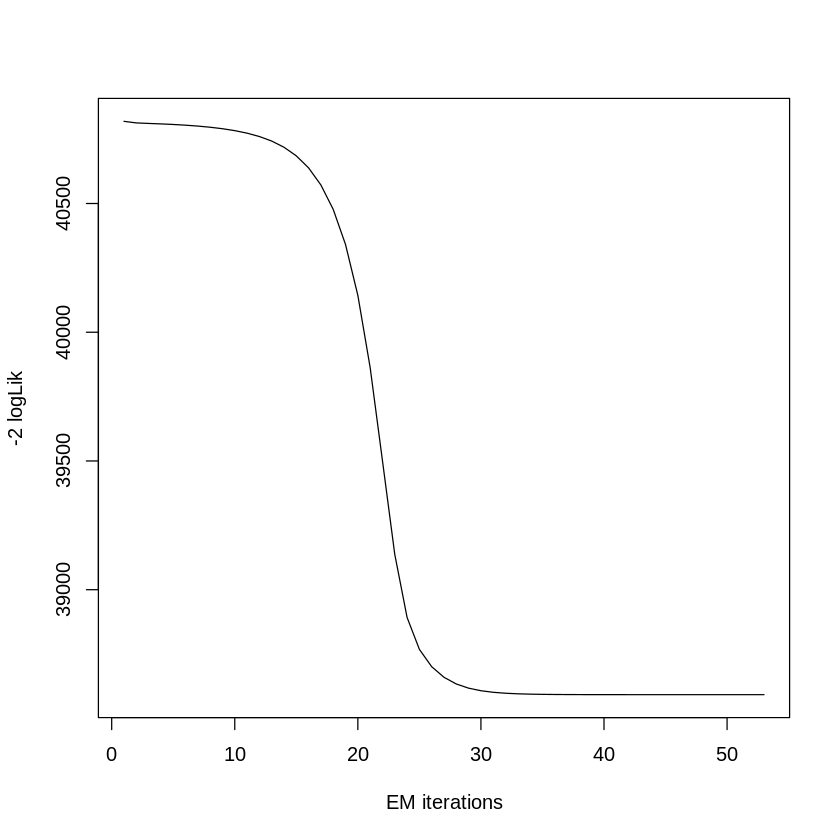

model= 1 


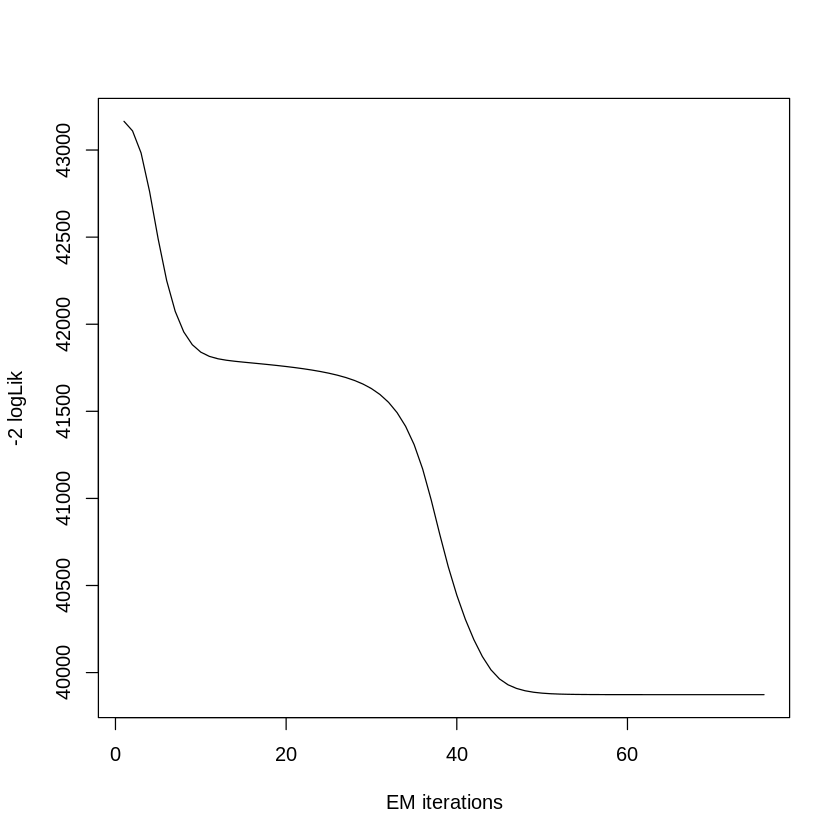

model= 1 


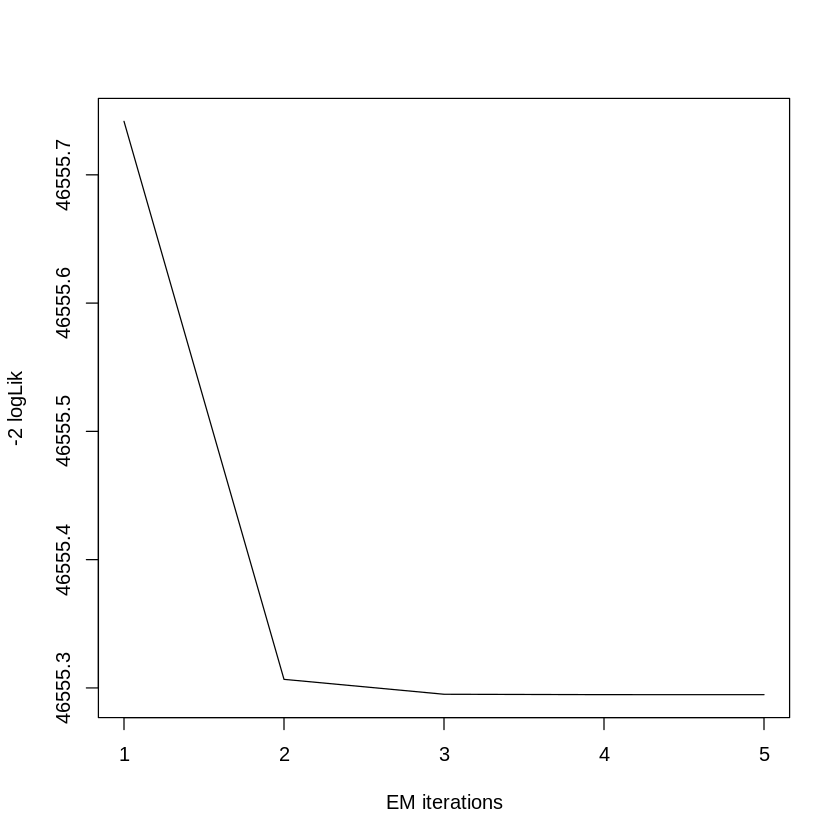

model= 1 


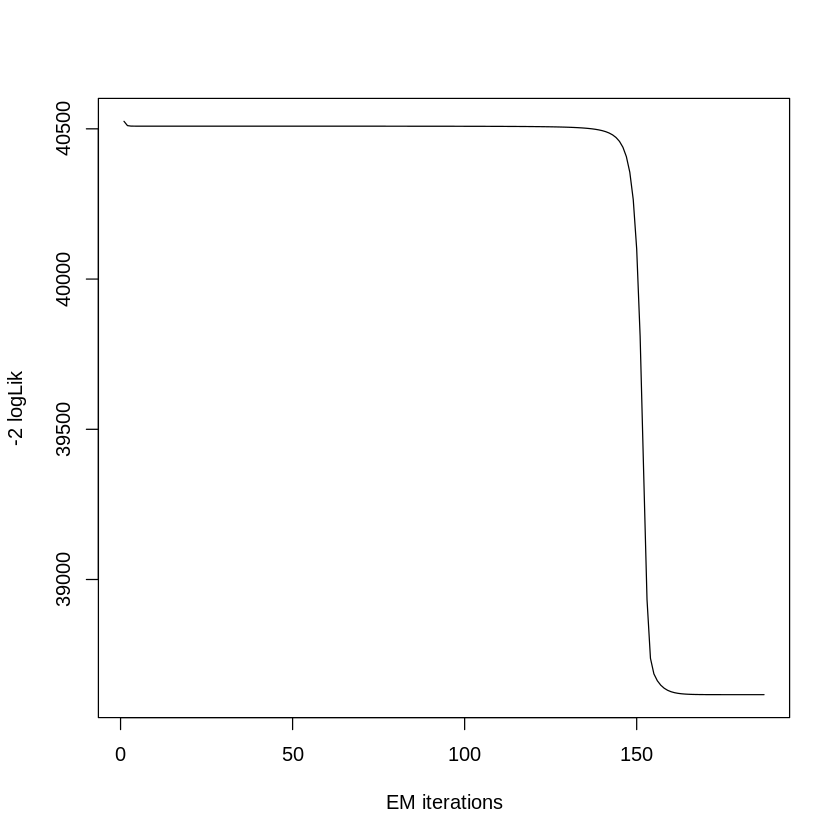

model= 1 


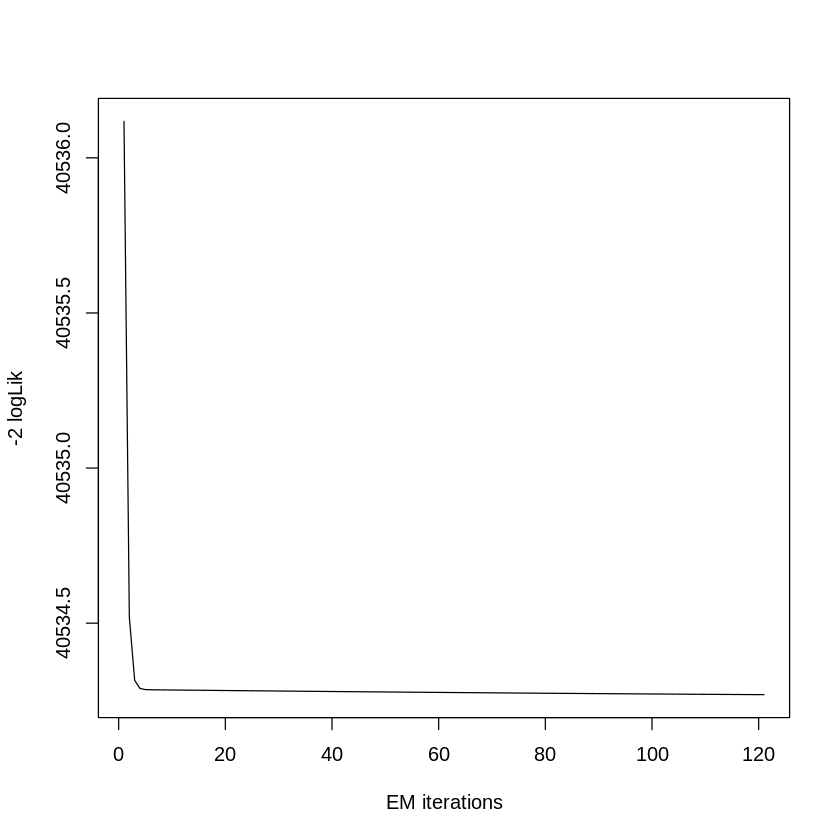

model= 1 


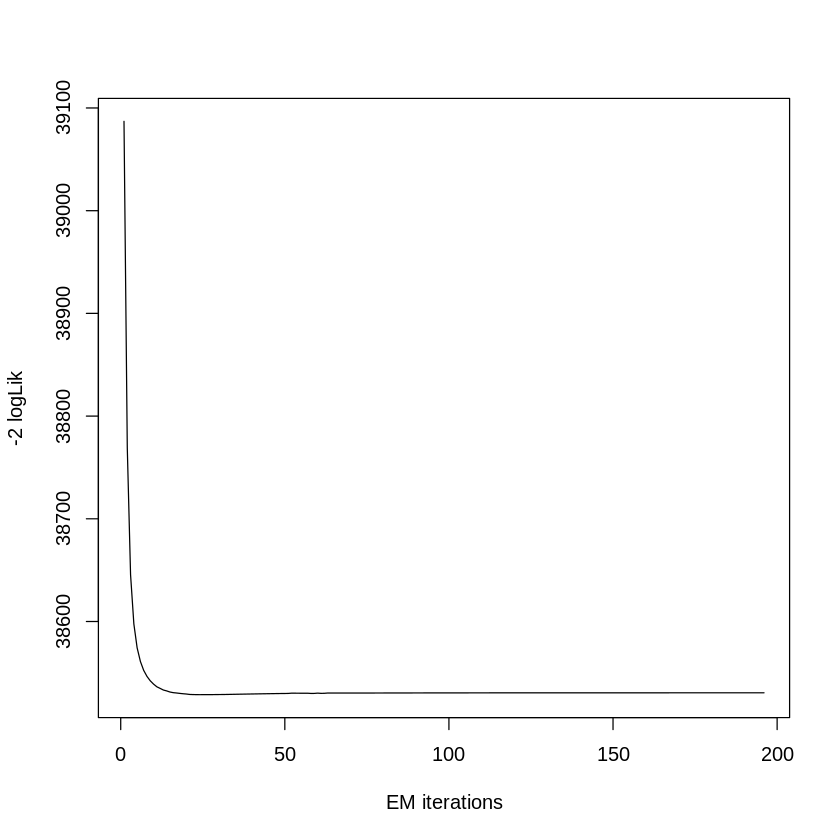

model= 1 


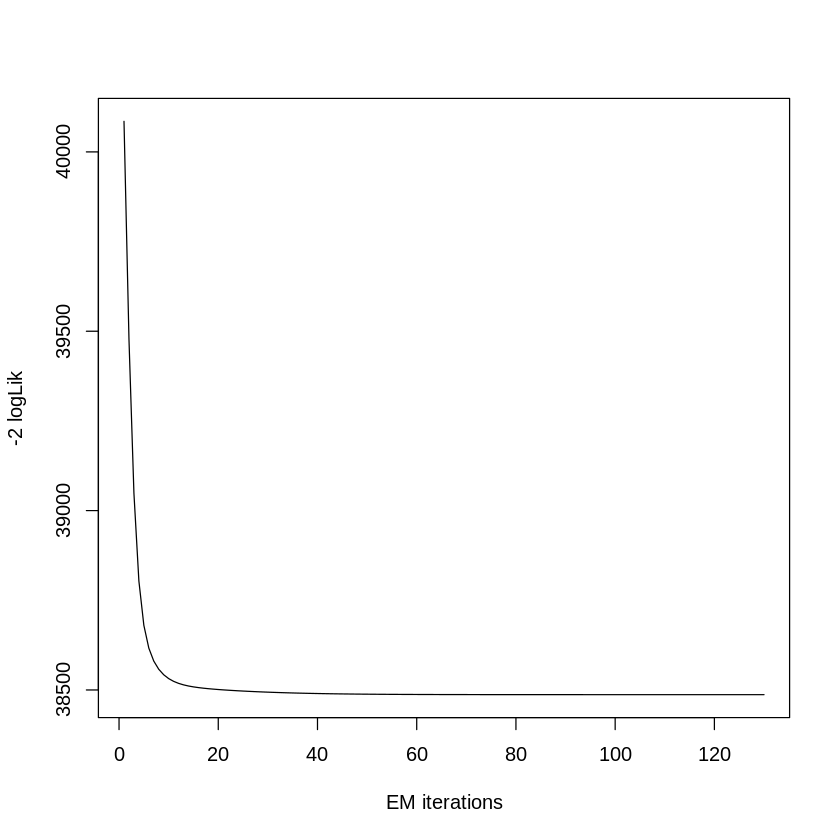

model= 1 


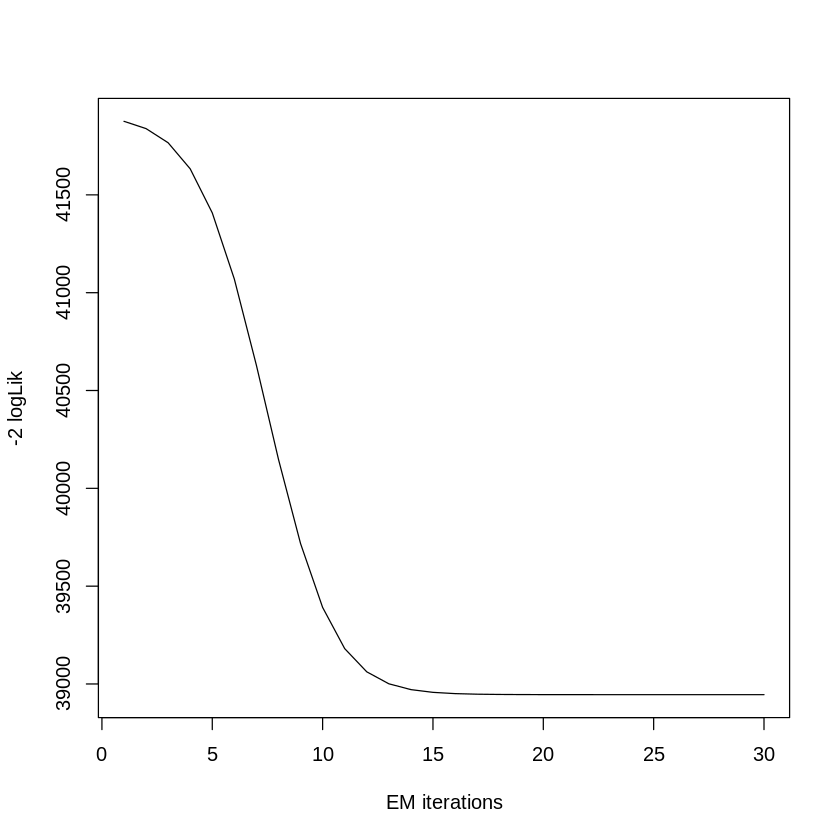

model= 1 


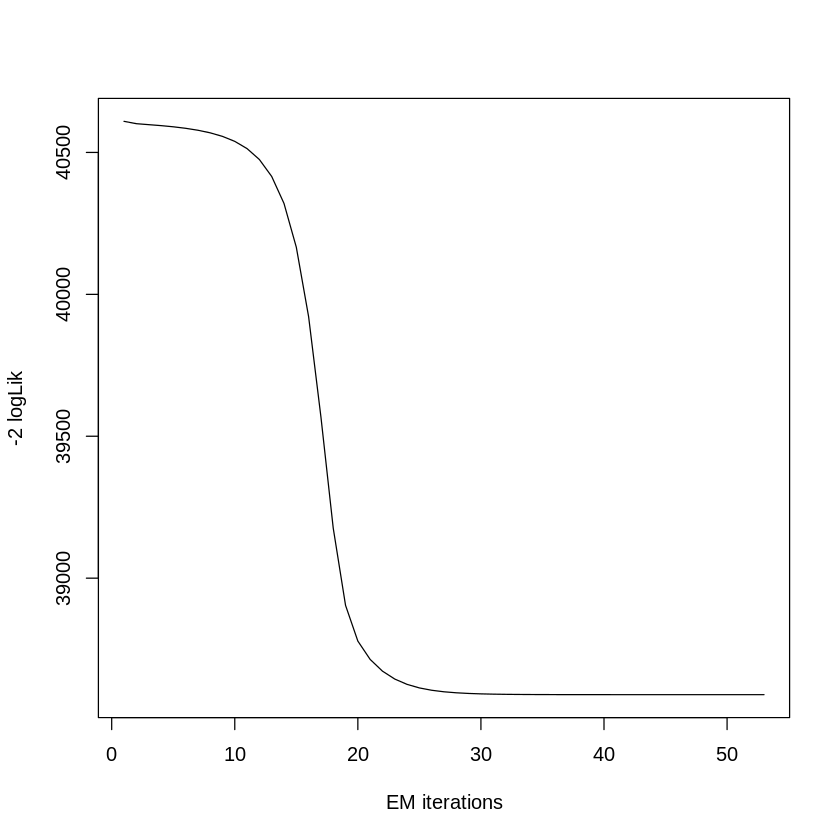

model= 1 
[1] "best family according the majority rule: GG"


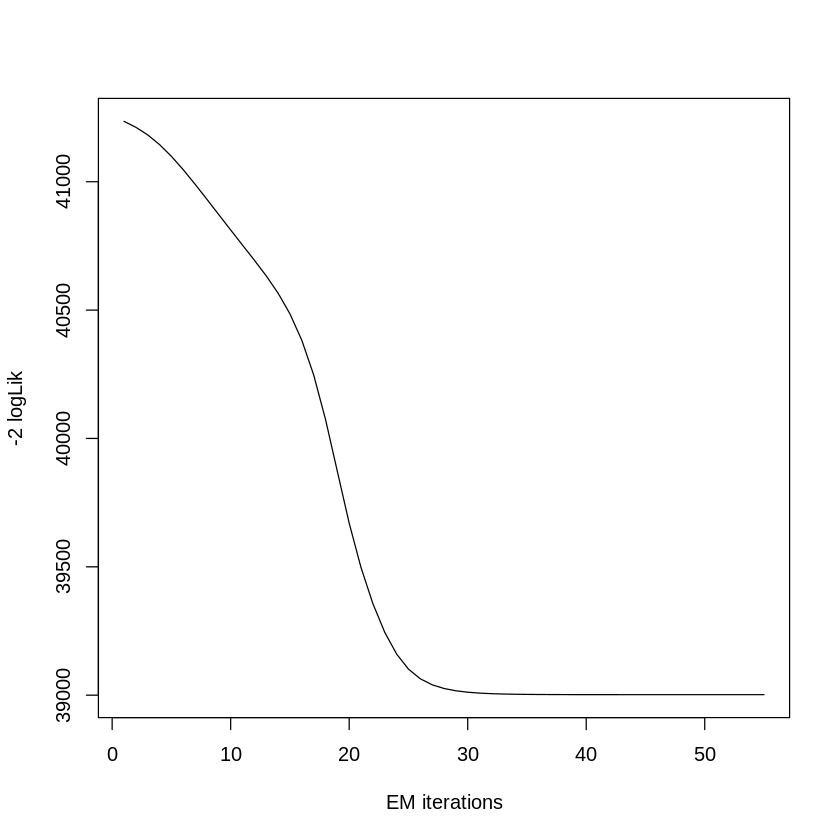

In [22]:
tests <- test.all.gamlss.mx(insurance.data$Age, k = 2)

According to the test the best family is the **Generalized Gamma**, let's see the plot

model= 1 


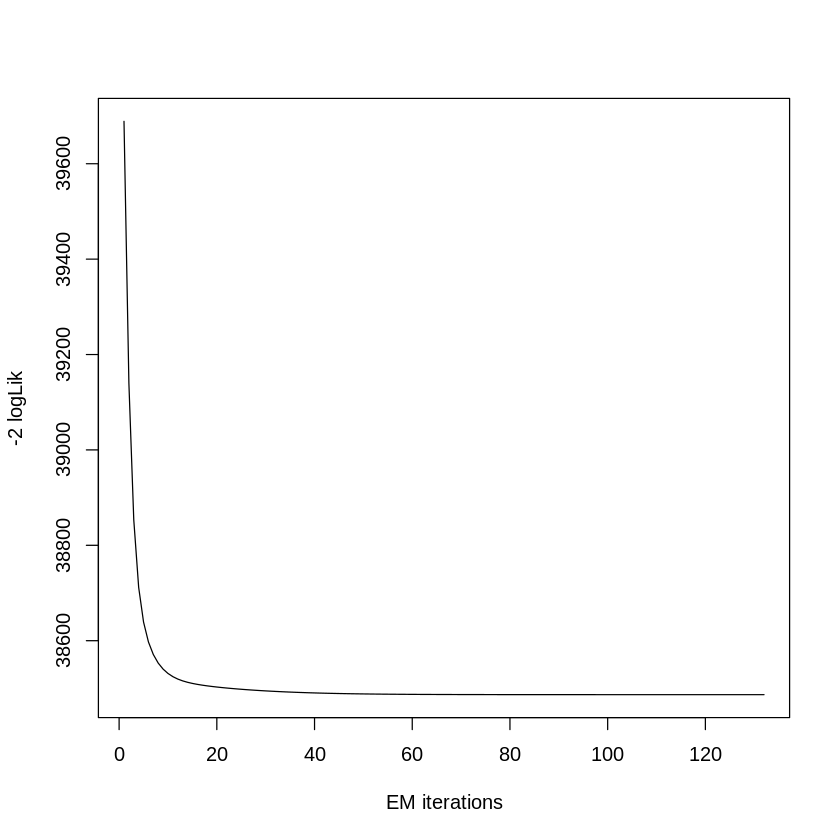

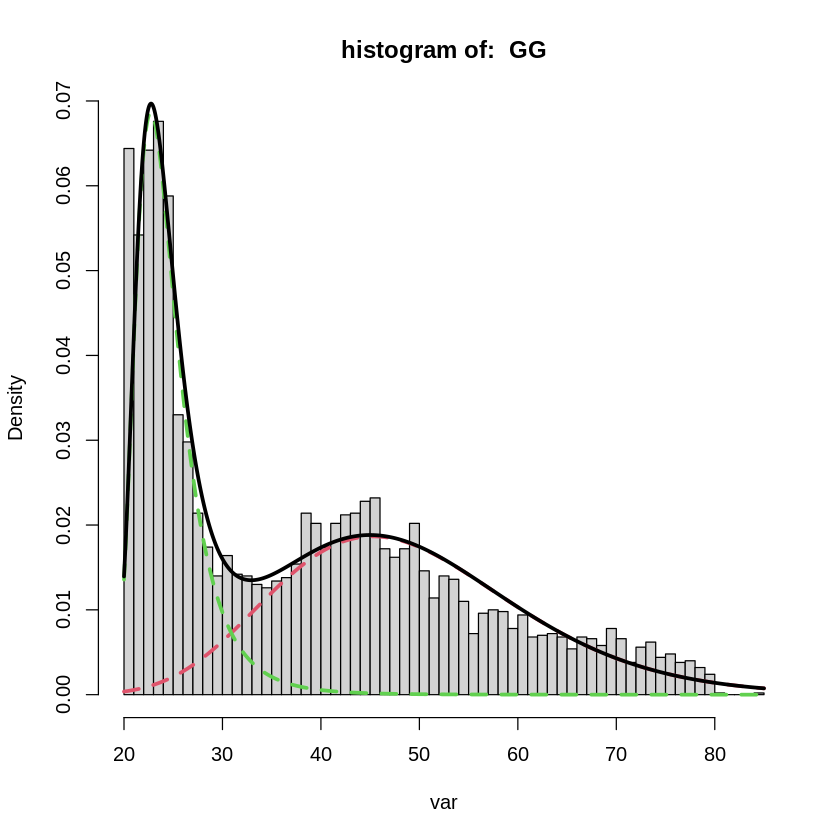

In [24]:
fit.GG <- gamlssMXfits(n=1,Age~1,data = insurance.data, family=GG, K=2)

mu <- get.mu.hats(fit.GG, 2)
sigma <- get.sigma.hats(fit.GG, 2)
nu <- get.nu.hats(fit.GG, 2)

plot.gamlss(var = insurance.data$Age, family = "GG", fit = fit.GG, K = 2, mu.hats = mu, sigma, nu)

This family fitted the data in a very nice way!

### 1.4. Driving_License

In [65]:
str(insurance.data$Driving_License)

table(insurance.data$Driving_License)

 Factor w/ 2 levels "No","Yes": 2 2 2 2 2 2 2 2 2 2 ...



  No  Yes 
  12 4988 

This is an integer variable and it may be ambiguous since it could count how many driving licenses one person has (car, truck, motorbike, ...) or it could just be a boolean value indicating if one person has a driving lincense or not.

First of all we will see how the data are distributed

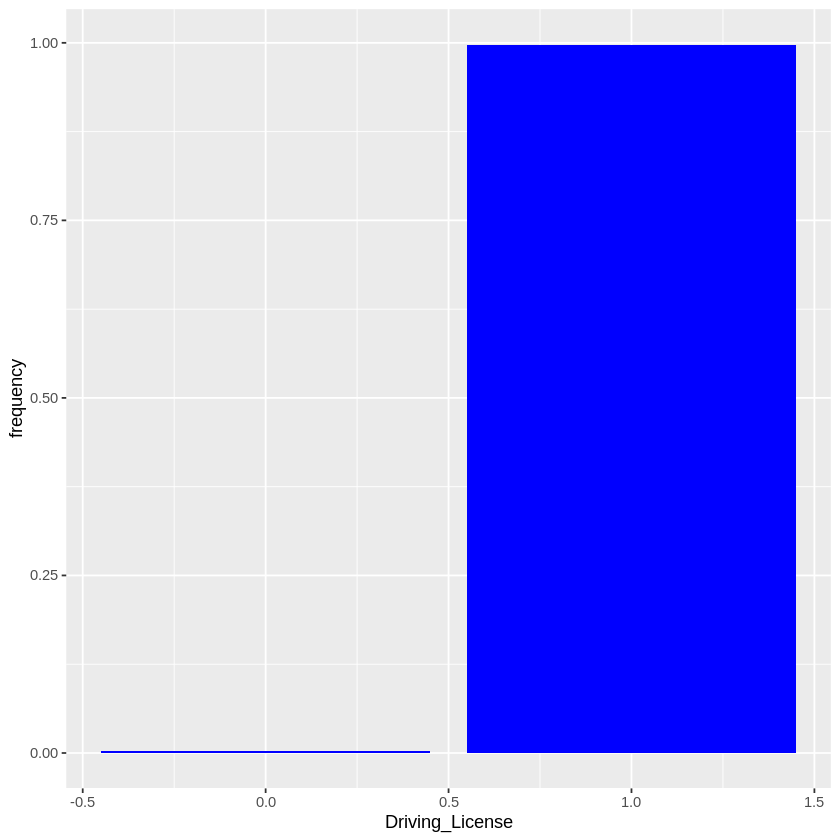

In [26]:
insurance.data %>%
    ggplot(aes(x = Driving_License)) +
    geom_bar(aes(y = (..count..)/sum(..count..)),, fill = "blue") +
    ylab("frequency")

As we can see the variable act like a boolean one. This variable seems to be pretty useless since approximately the $100\%$ of the people has a driving license.

But, the absence of the driving license may significantly change the premium amount and be a crucial factor in the response of the non-driving people.

In order to make the dataset consistent we will transform this variable in a categorical one

In [27]:
insurance.data$Driving_License <- as.factor(if_else(insurance.data$Driving_License == 1, "Yes", "No"))

### 1.5. Region_Code

In [60]:
str(insurance.data$Region_Code)

summary(insurance.data$Region_Code)

 num [1:5000] 11 47 50 23 22 41 10 14 11 29 ...


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   15.00   28.00   26.51   35.00   52.00 

This integer variable contains an unique code for the region of the customer. Let's see the distribution

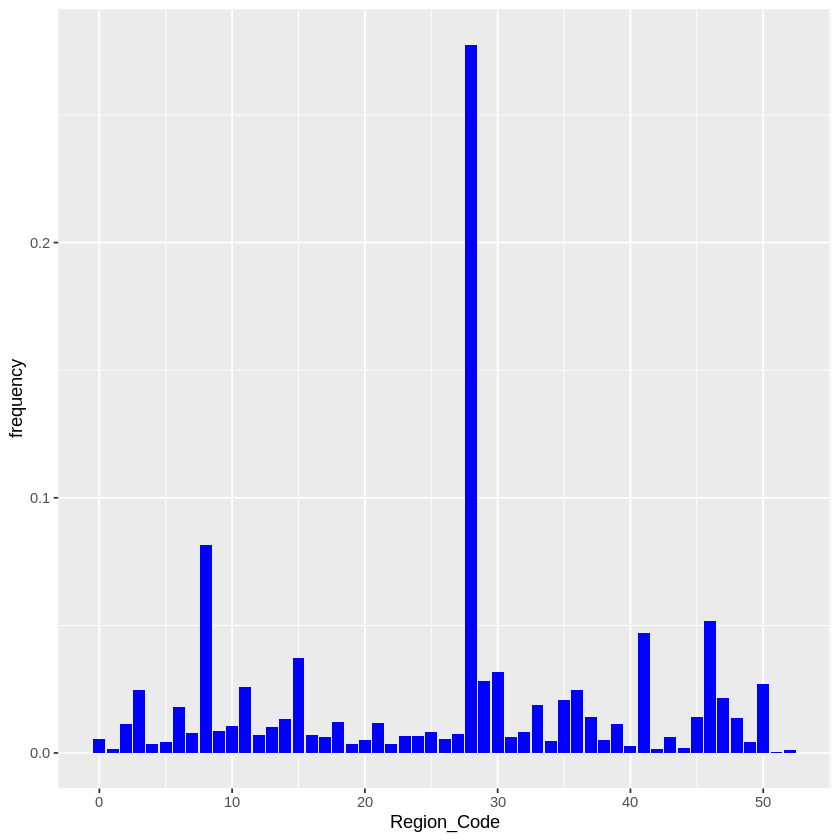

In [29]:
insurance.data %>%
    ggplot(aes(x = Region_Code)) +
    geom_bar(aes(y = (..count..)/sum(..count..)),fill = "blue") +
    ylab("frequency")

from this graph we can see that most of the customers come from $7$ of the $52$ regions.

Since this seems to be a multimodal variable we will fit all the families as we did before.

Error in gamlss(allFormula[[i]], weights = wei, , data = data, family = allFamily[[i]],  : 
  response variable out of range
model= 1 failed 
[1] "Error in GA, passing over..."
model= 1 
Error in gamlss(allFormula[[i]], weights = wei, , data = data, family = allFamily[[i]],  : 
  response variable out of range
model= 1 failed 
[1] "Error in EXP, passing over..."
Error in while (abs(G.dev.old - G.dev) > c.crit && iter < n.cyc) { : 
  missing value where TRUE/FALSE needed
model= 1 failed 
[1] "Error in IGAMMA, passing over..."
Error in gamlss(allFormula[[i]], weights = wei, , data = data, family = allFamily[[i]],  : 
  response variable out of range
model= 1 failed 
[1] "Error in IG, passing over..."
Error in lm.wfit(X, wv, wt * w, method = "qr") : incompatible dimensions
model= 1 failed 
[1] "Error in JSU, passing over..."
Error in gamlss(allFormula[[i]], weights = wei, , data = data, family = allFamily[[i]],  : 
  response variable out of range
model= 1 failed 
[1] "Error in GG, passin

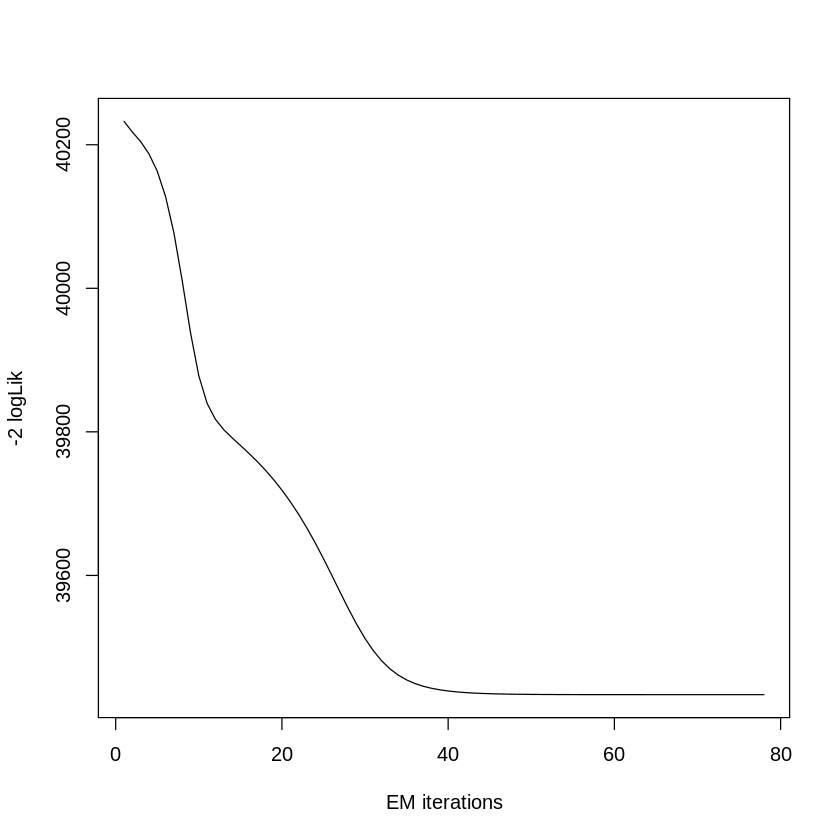

model= 1 
Error in gamlss(allFormula[[i]], weights = wei, , data = data, family = allFamily[[i]],  : 
  response variable out of range
model= 1 failed 
[1] "Error in LOGNO, passing over..."
Error in gamlss(allFormula[[i]], weights = wei, , data = data, family = allFamily[[i]],  : 
  response variable out of range
model= 1 failed 
[1] "Error in WEI, passing over..."
[1] "best family according the majority rule: LO"


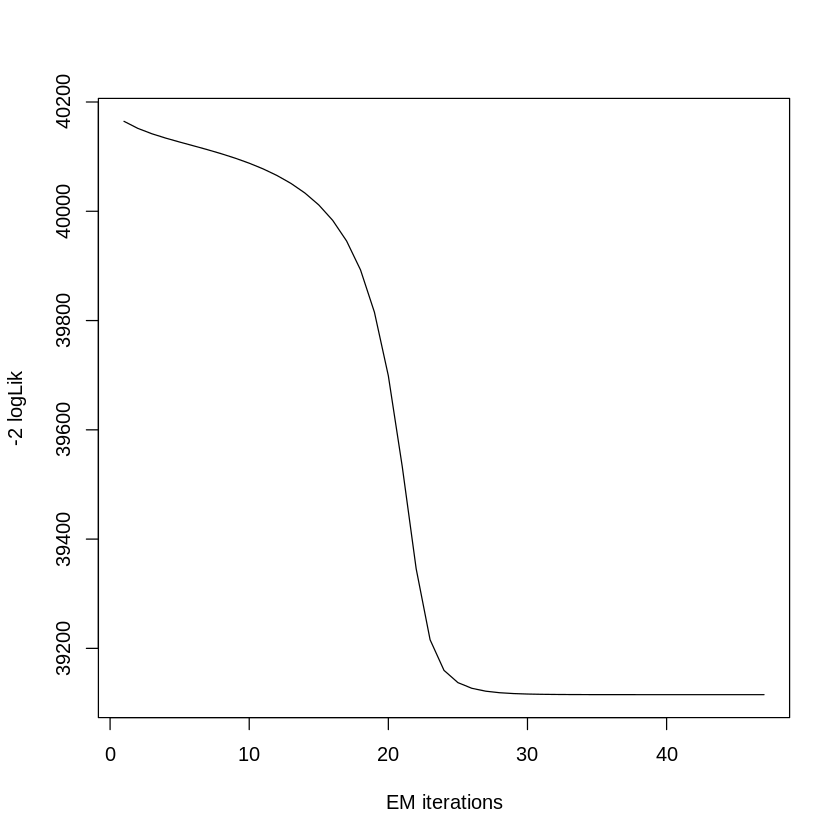

In [30]:
tests <- test.all.gamlss.mx(insurance.data$Region_Code, k = 2)

Our function gave us that the *LO* model has best result on both the metric!
Let's plot it.

model= 1 


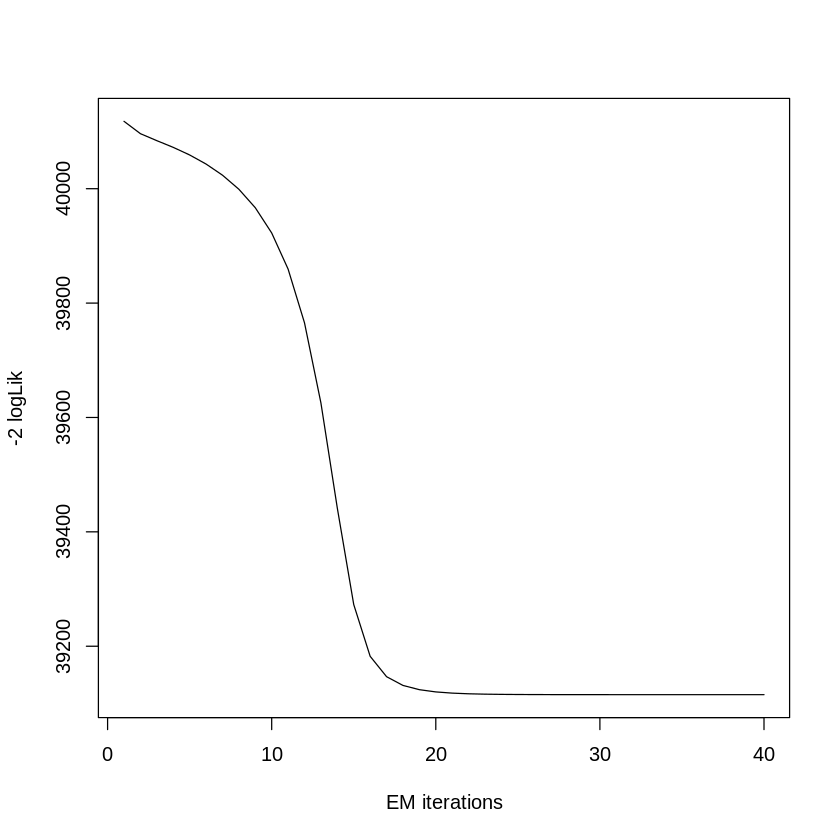

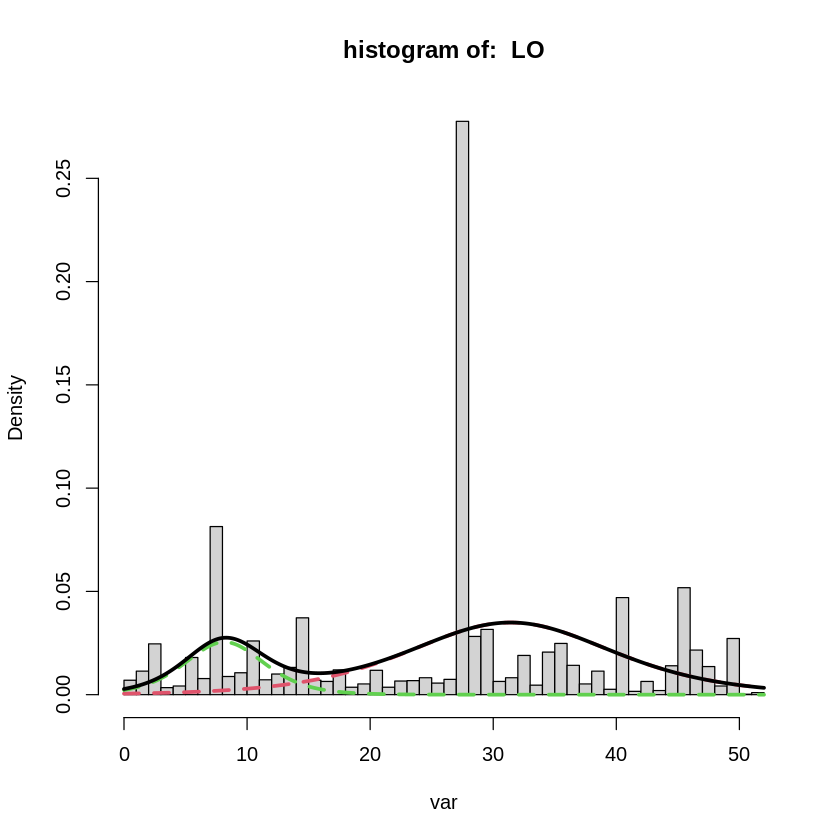

In [31]:
fit <- gamlssMXfits(n = 1, Region_Code~1, family = LO, K = 2, data = insurance.data)

mu <- get.mu.hats(fit, 2)
sigma <- get.sigma.hats(fit, 2)

plot.gamlss(var = insurance.data$Region_Code, family = "LO", fit = fit, K = 2, mu.hats = mu, sigma.hats = sigma)

Even the best model fits in a bad way our variable, but more or less it caught the main behaviour of the data.

### 1.6. Previously_Insured

In [66]:
str(insurance.data$Previously_Insured)

table(insurance.data$Previously_Insured)

 Factor w/ 2 levels "No","Yes": 1 1 2 2 2 2 1 1 2 1 ...



  No  Yes 
2670 2330 

This is another integer logical like variable that contains information about any previous vehicle insurance. 

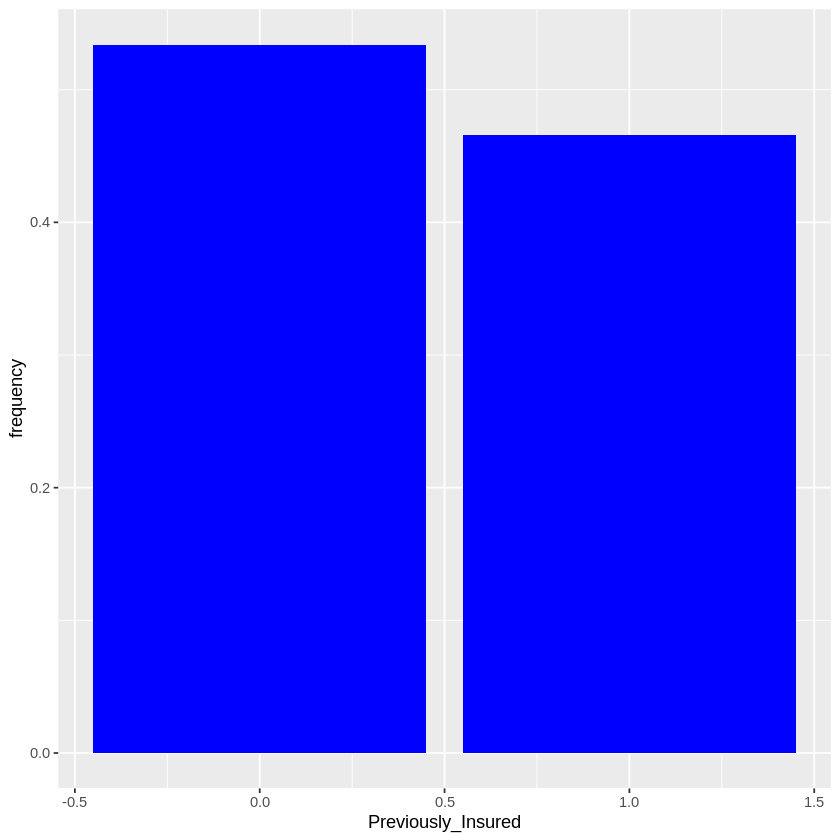

In [33]:
insurance.data %>%
    ggplot(aes(x = Previously_Insured, fill = Previously_Insured)) +
    geom_bar(aes(y = (..count..)/sum(..count..)), fill = "blue") +
    ylab("frequency")

Also this variable seems to be pretty equally distributed with a small overcoming of people with have no any insurance yet, has to be noted that this could be related to the fact that the most part of the dataset is composed by young people with their (probably) first car!

Let's make this variable categorical

In [34]:
insurance.data$Previously_Insured <- as.factor(if_else(insurance.data$Previously_Insured == 1, "Yes", "No"))

### 1.7. Vehicle_Age

In [67]:
str(insurance.data$Vehicle_Age)

table(insurance.data$Vehicle_Age)

 int [1:5000] 1 1 2 1 1 1 2 1 1 2 ...



   1    2    3 
2197 2613  190 

This variable is a 3 levels factor, since the car's age is an important factor due to the amount of the annual premium, it could make sense to think that the older it is the higher the prize will be, we need to make sure these factors are ordered

In [36]:
is.ordered(insurance.data$Vehicle_Age)

[1] FALSE

The variable is not ordered, so we have to do this by our own

In [37]:
levels(insurance.data$Vehicle_Age)

NULL

In [38]:
# ordering the factors
insurance.data$Vehicle_Age <- ordered(insurance.data$Vehicle_Age, levels = c('< 1 Year','1-2 Year', '> 2 Years'))

# check if the variable becomes ordered
is.ordered(insurance.data$Vehicle_Age)

[1] TRUE

In [39]:
# check that the order is correct
print(head(insurance.data$Vehicle_Age))

[1] < 1 Year < 1 Year 1-2 Year < 1 Year < 1 Year < 1 Year
Levels: < 1 Year < 1-2 Year < > 2 Years


Now we can see how the factors are distributed

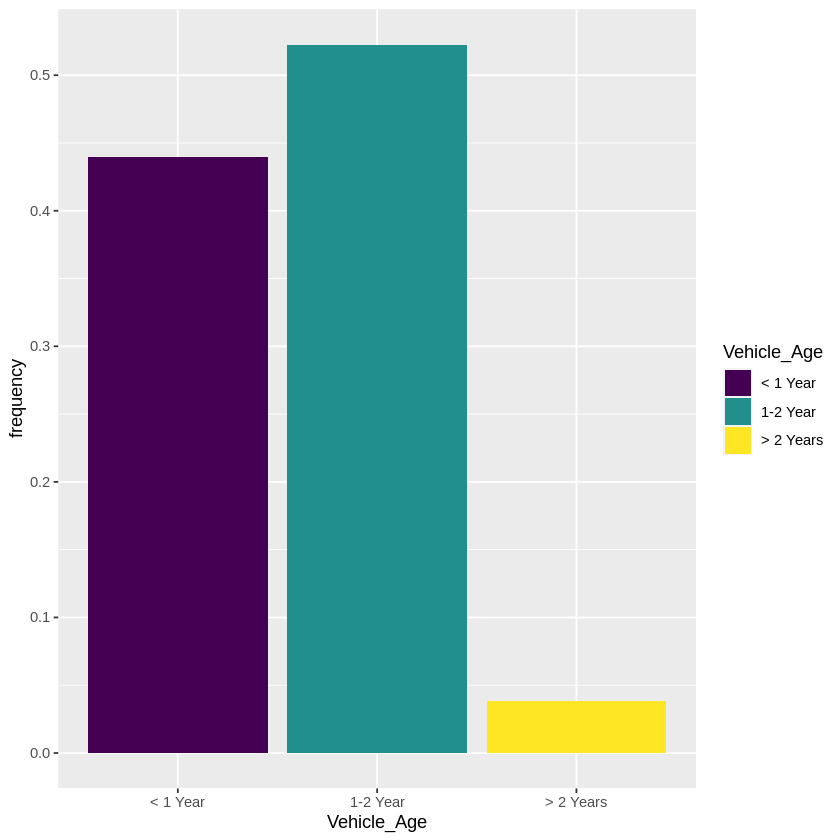

In [40]:
insurance.data %>%
    ggplot(aes(x = Vehicle_Age, fill = Vehicle_Age)) +
    geom_bar(aes(y = (..count..)/sum(..count..))) +
    ylab("frequency")

The majority of the cars are pretty new, so may have sense to think that this variable has not a lot of utility.

Since it is an ordered categorical variable we preffer to transform it in a numeric variable

In [41]:
insurance.data$Vehicle_Age <- as.integer(insurance.data$Vehicle_Age)

### 1.8. Vehicle_Damage	

In [68]:
str(insurance.data$Vehicle_Damage)

table(insurance.data$Vehicle_Damage)

 Factor w/ 2 levels "No","Yes": 2 2 1 1 1 1 2 2 1 2 ...



  No  Yes 
2513 2487 

This is a char variable acting like a 2-level factorial variable, containing information on whether or not the customer got his/her vehicle damaged. 

We are going to transform it in a factor variable.

In [43]:
insurance.data$Vehicle_Damage <- as.factor(insurance.data$Vehicle_Damage)


Let's see the distribution

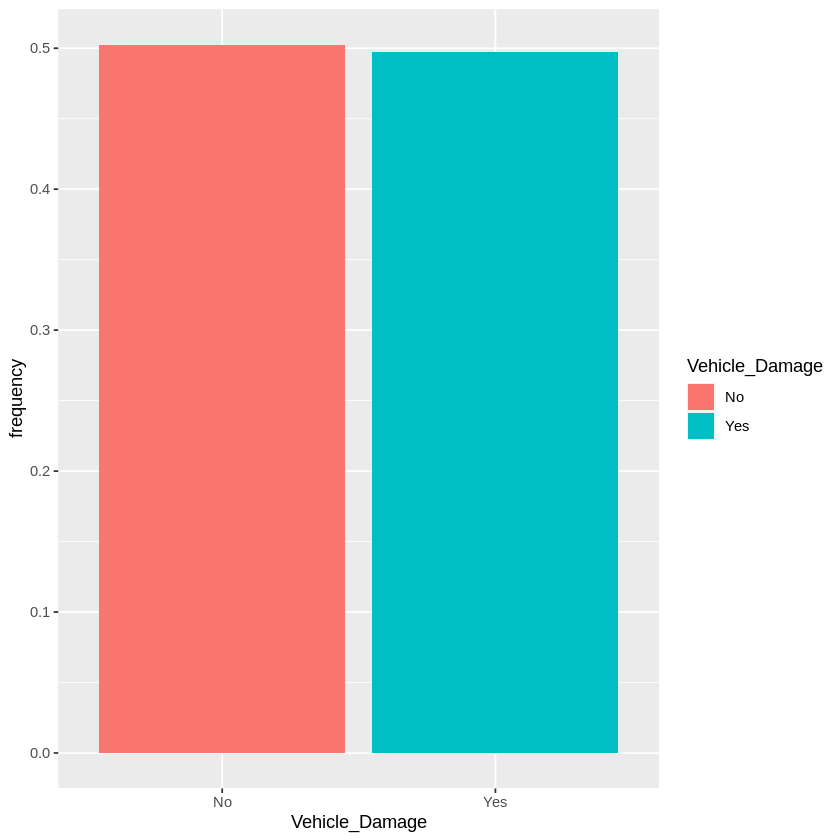

In [44]:
insurance.data %>%
    ggplot(aes(x = Vehicle_Damage, fill = Vehicle_Damage)) +
    geom_bar(aes(y = (..count..)/sum(..count..))) +
    ylab("frequency")

The variable is 
almost perfectly balanced, so no comments can be made

### 1.9. Annual_Premium

In [61]:
str(insurance.data$Annual_Premium)

summary(insurance.data$Annual_Premium)

 num [1:5000] 43273 33473 49929 2630 26989 ...


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2630   24332   31598   30656   39516  227526 

Numerical variable indicating the amount customer needs to pay as premium in the year

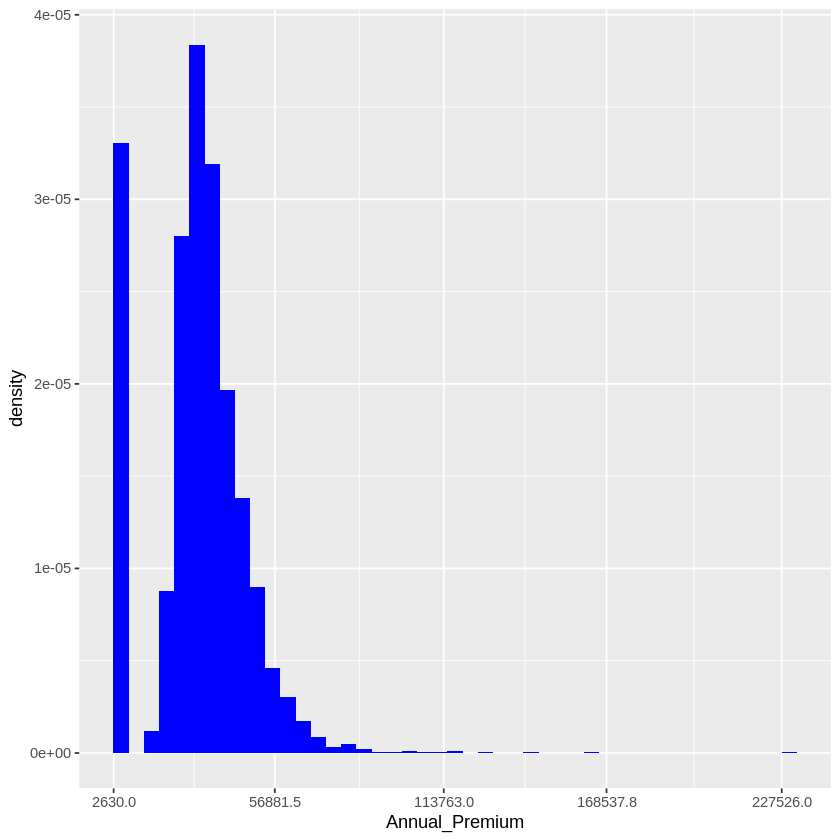

In [46]:
# get some break points for a better visualization of the x-axis
breaks.x <- c(
    min(insurance.data$Annual_Premium),
    max(insurance.data$Annual_Premium)/4,
    max(insurance.data$Annual_Premium)/2,
    max(insurance.data$Annual_Premium)/1.35,
    max(insurance.data$Annual_Premium))
    
insurance.data %>%
    ggplot(aes(x = Annual_Premium)) +
    geom_histogram(aes(y = ..density..),bins = 45, fill = "blue") +
    scale_x_continuous(breaks = breaks.x)

We can see that the most premium is in the interval $(2630,115000)$ with a really low number of people which falls out of that interval.

This variable seems to be unimodal, so we will fit a single distribution on this variable.

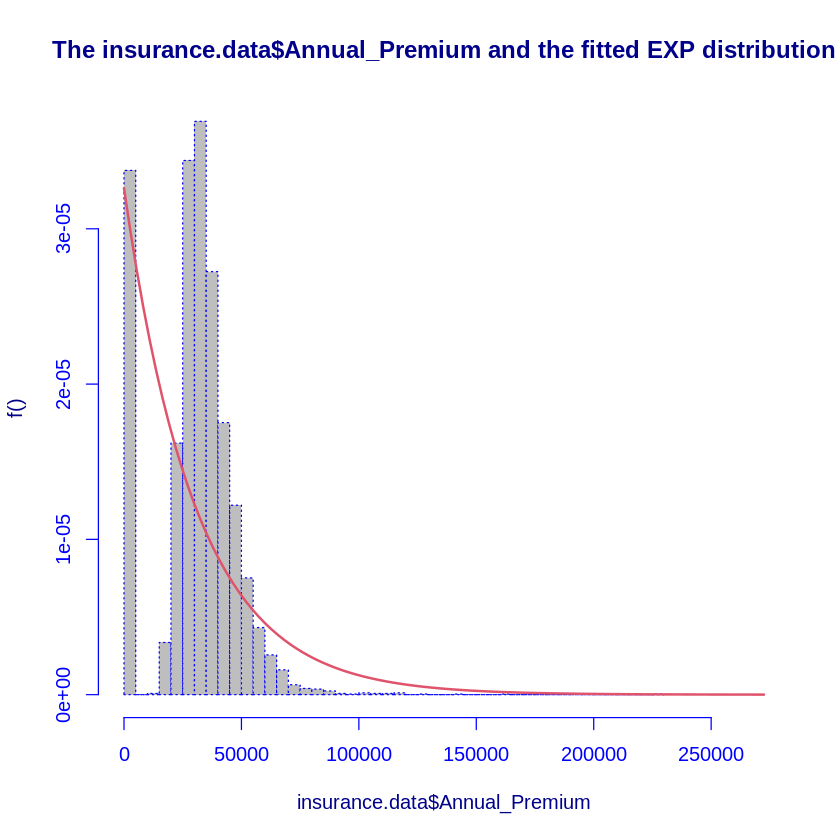

In [47]:
EXP.fit <- histDist(insurance.data$Annual_Premium, family = EXP, nbins = 70)

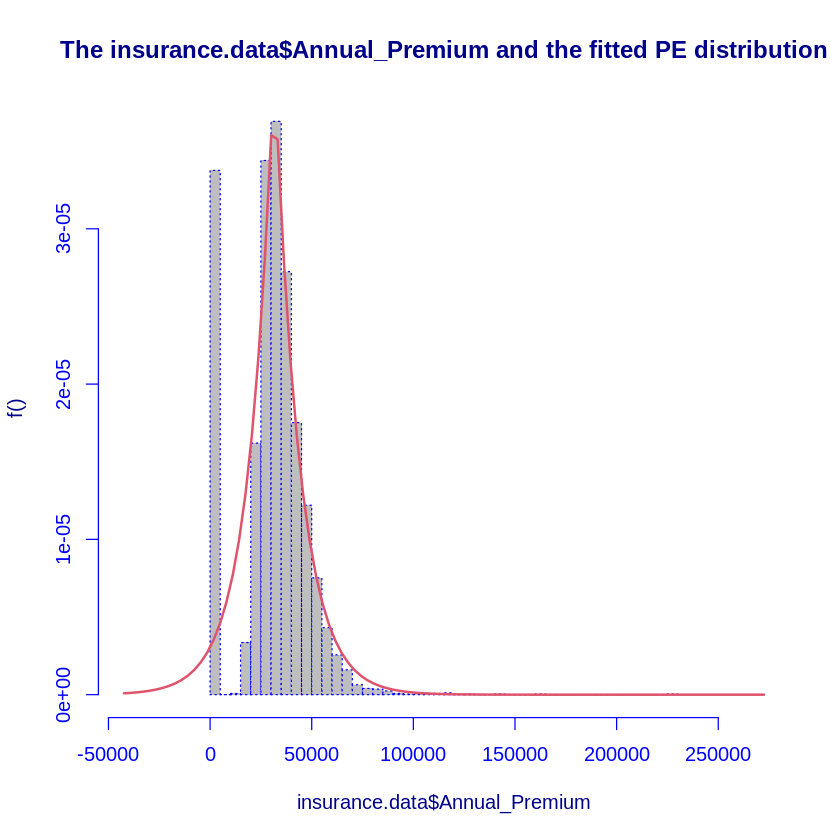

In [48]:
PE.fit <- histDist(insurance.data$Annual_Premium, family = PE, nbins = 40)

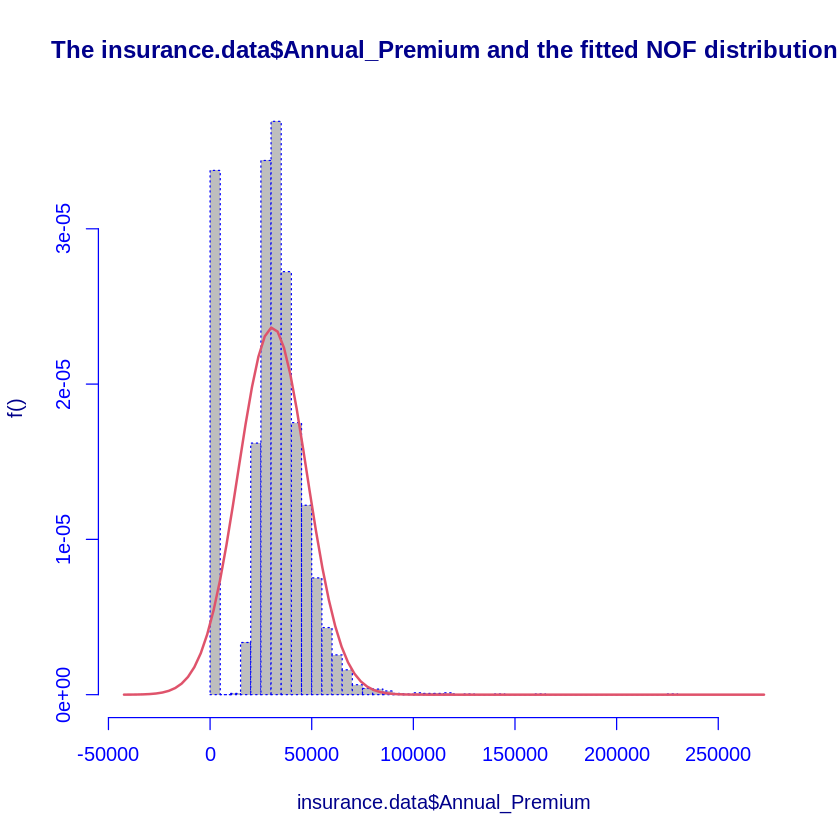

In [49]:
WEI.fit <- histDist(insurance.data$Annual_Premium, family = NOF, nbins = 40)

The single distributions seems to not work properly, so we will fit a bivariate model as usual

model= 1 
Error in while (abs(olddv - newdv) > control$cc && iter.num < control$n.cyc) { : 
  missing value where TRUE/FALSE needed
model= 1 failed 
[1] "Error in GU, passing over..."


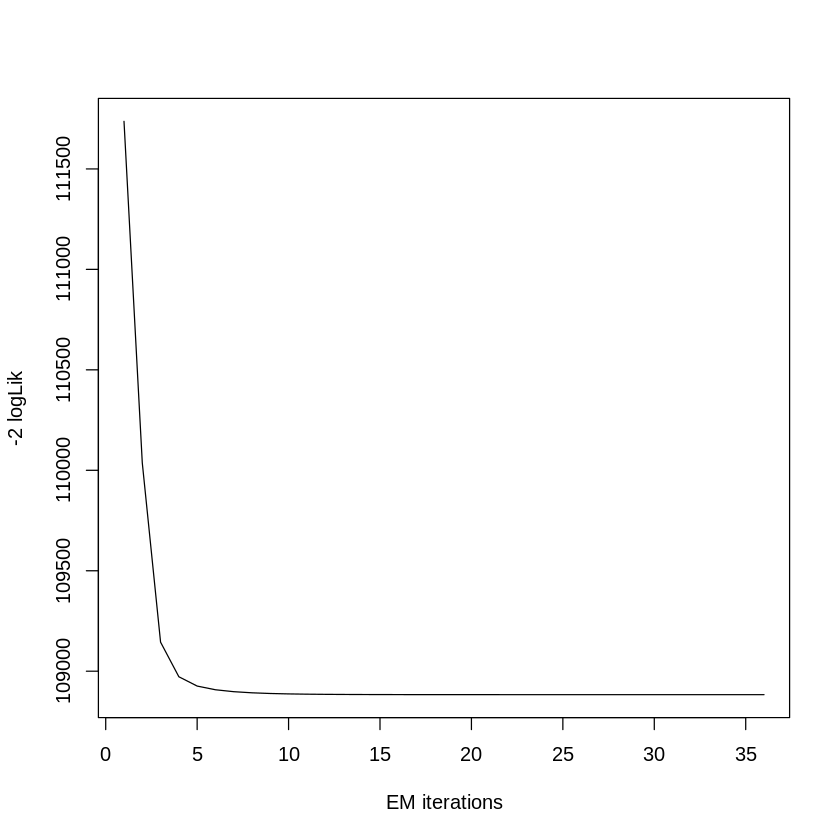

model= 1 
Error in if (dv > olddv && itn >= 2 && auto == TRUE) { : 
  missing value where TRUE/FALSE needed
model= 1 failed 
[1] "Error in IGAMMA, passing over..."
Error in if (dv > olddv && itn >= 2 && auto == TRUE) { : 
  missing value where TRUE/FALSE needed
model= 1 failed 
[1] "Error in IG, passing over..."
Error in while (abs(olddv - dv) > cc && itn < cyc) { : 
  missing value where TRUE/FALSE needed
model= 1 failed 
[1] "Error in JSU, passing over..."
Error in while (abs(olddv - newdv) > control$cc && iter.num < control$n.cyc) { : 
  missing value where TRUE/FALSE needed
model= 1 failed 
[1] "Error in GG, passing over..."


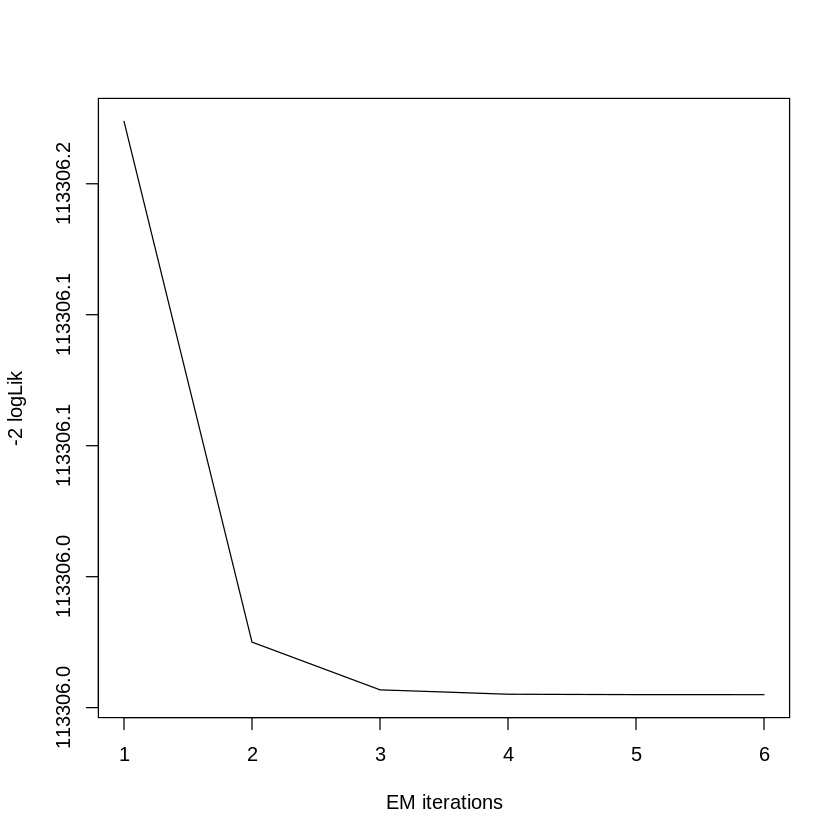

model= 1 
Error in if (dv > olddv && itn >= 2 && auto == TRUE) { : 
  missing value where TRUE/FALSE needed
model= 1 failed 
[1] "Error in LOGNO, passing over..."


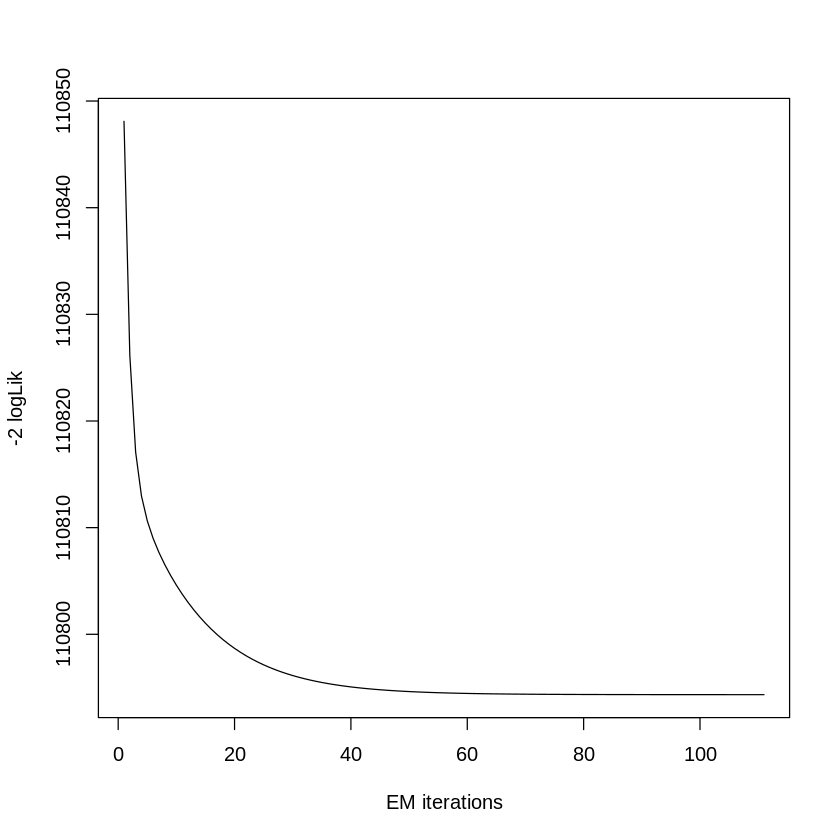

model= 1 
[1] "best family according the majority rule: GA"


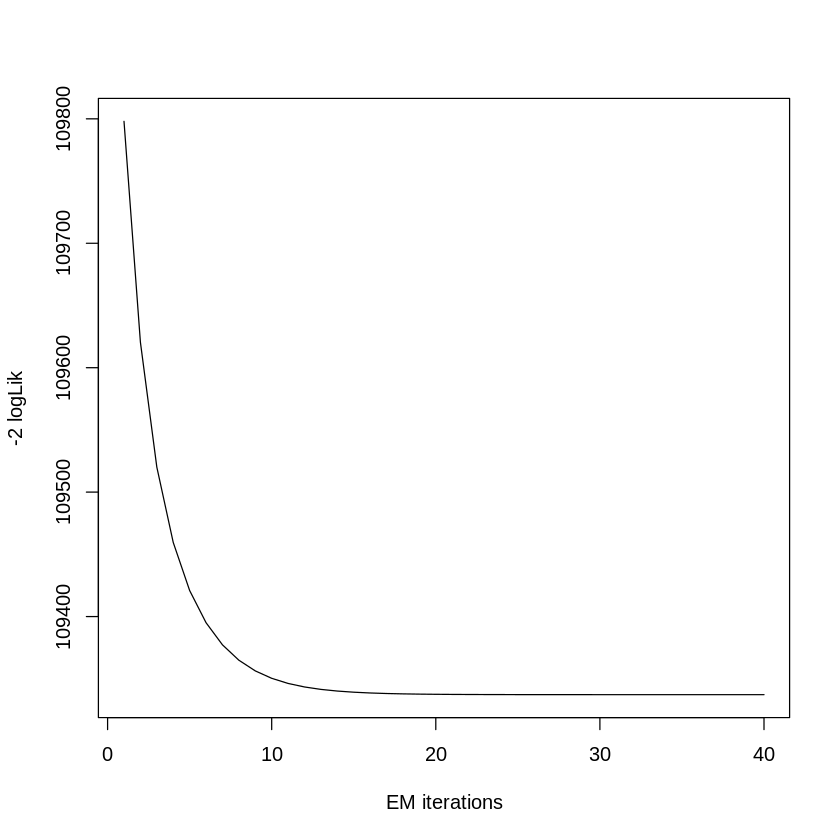

In [50]:
tests <- test.all.gamlss.mx(insurance.data$Annual_Premium, k = 2)

model= 1 


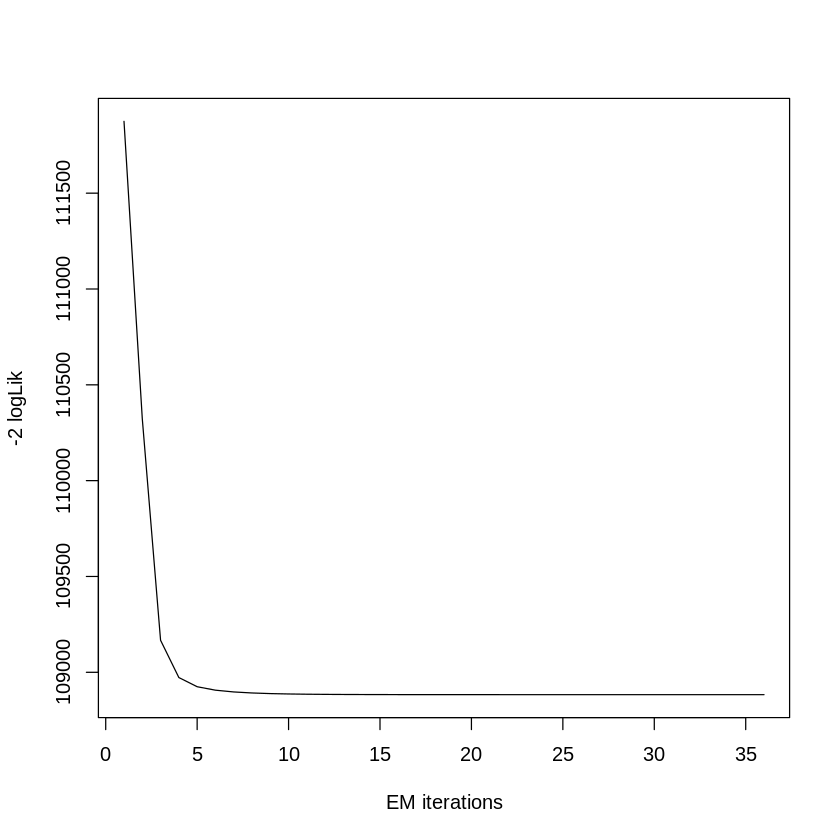

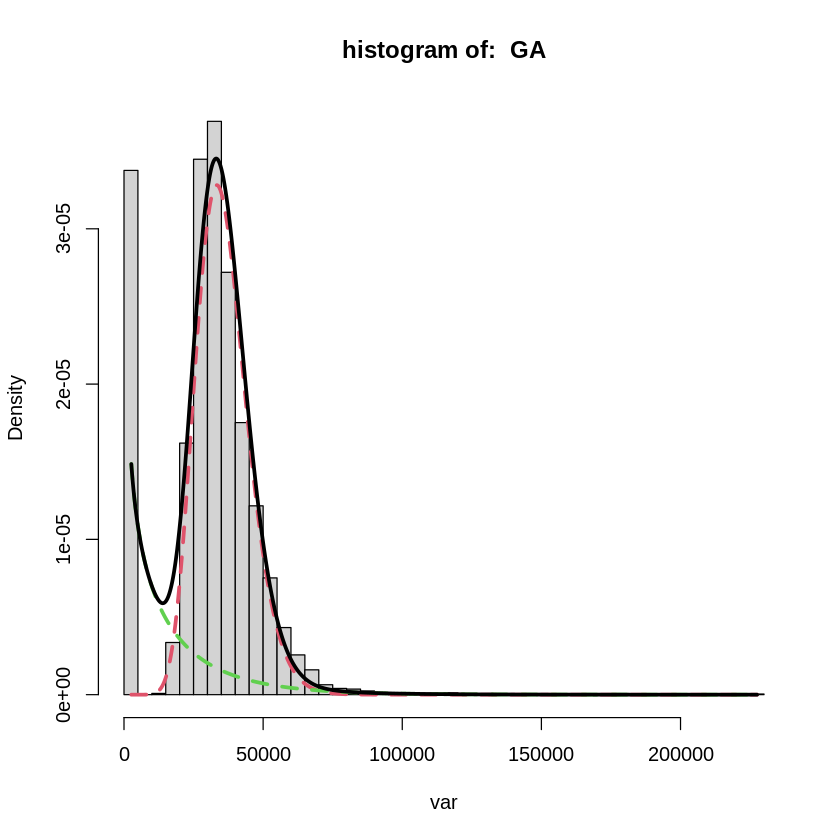

In [51]:
fit.GA <- gamlssMXfits(n = 1, Annual_Premium~1, family = GA, K = 2, data = insurance.data)


mu <- get.mu.hats(fit.GA, 2)
sigma <- get.sigma.hats(fit.GA, 2)

plot.gamlss(var = insurance.data$Annual_Premium, family = "GA", fit = fit.GA, K = 2, mu.hats = mu, sigma.hats = sigma)

As we can see using two models helped a lot but we are still far away from a perfect fit!

### 1.10. Policy_Sales_Channel

In [62]:
str(insurance.data$Policy_Sales_Channel)

summary(insurance.data$Policy_Sales_Channel)

 num [1:5000] 124 160 8 160 152 152 124 152 152 124 ...


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    52.0   151.0   113.1   152.0   163.0 

This variable contains anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

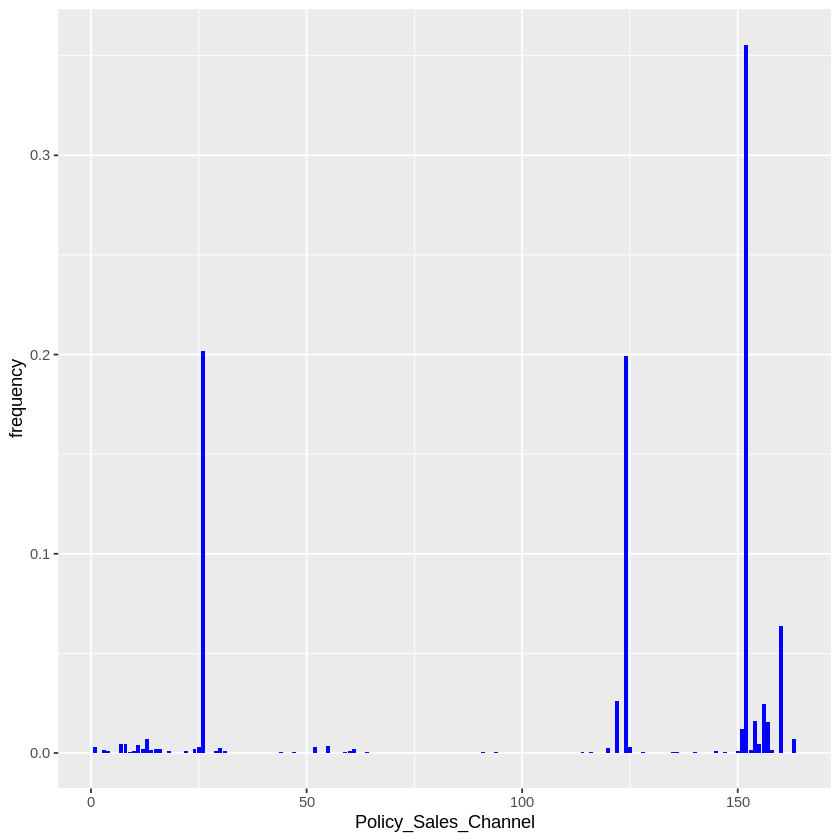

In [53]:
insurance.data %>%
    ggplot(aes(x = Policy_Sales_Channel)) +
    geom_bar(aes(y = (..count..)/sum(..count..)),fill = "blue") +
    ylab("frequency")

There are few main policy sales channels, but due to the fact that there are no informations about what a channel refers to, we can't do any discussion.

### 1.11. Vintage

In [63]:
str(insurance.data$Vintage)

summary(insurance.data$Vintage)

 int [1:5000] 136 258 68 280 62 204 294 76 265 47 ...


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   10.0    80.0   152.0   152.7   225.0   299.0 

This variable contains the number of days a customer has been associated with the company. The fidelity of a person could be a nice bias in order to sign the contract. 

Let's see the distribution

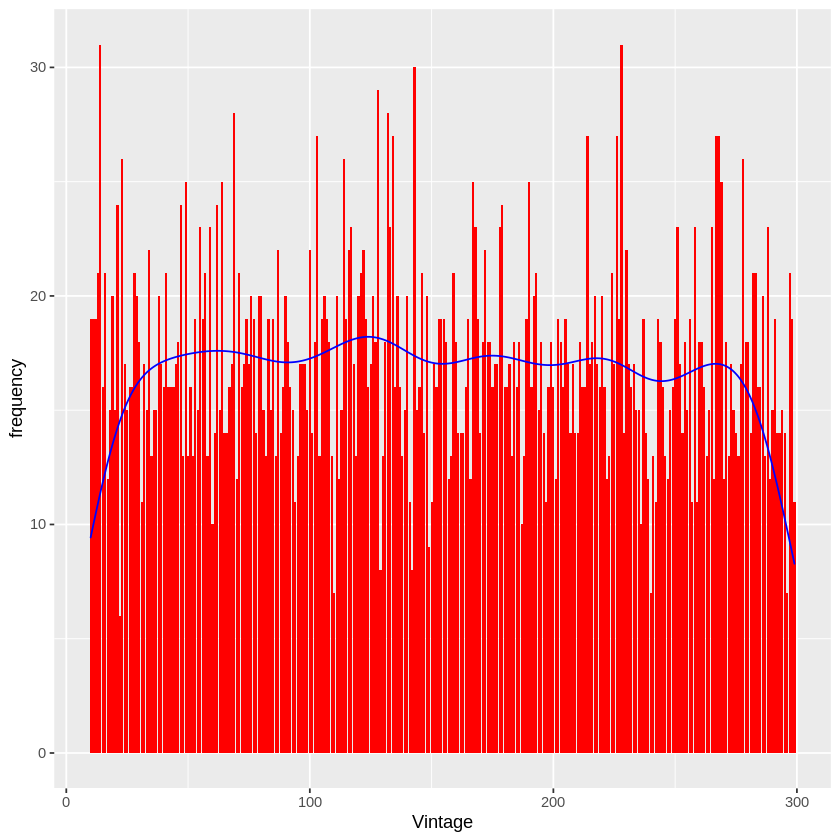

In [55]:
insurance.data %>%
    ggplot(aes(x = Vintage)) +
    geom_bar(aes(y = ..count..),fill = "red") +
    geom_density(aes(y = ..count..),color = "blue") +
    ylab("frequency")

The variable seems to be uniformly distributed.

Let's test this whit a significance level $\alpha = 0.05$.

In [56]:
scaled.vintage <- scale(insurance.data$Vintage, scale = T, center = F)
min <- min(scaled.vintage)
max <- max(scaled.vintage)
test <- spgs::chisq.unif.test(scaled.vintage, interval = c(min,max), bins = nrow(insurance.data))
test$p.value

[1] 0.1202489

Since whe have that $p-value > \alpha = 0.05$ the test told us that we cannot reject the hypotesis that the variable is uniformly distributed!

We have that the dataset is equally distributed between fresh customers and older ones. But also the older ones are customers for less than one year!

### 1.12. Response

This is the label column, since we want do some unsupervised analysis we will take it away from the dataset and saving in a separate variable. We will look at this variable only to do external clustering validation causo looking at it during our analysis could be an high bias on our analysis and choices.

In [57]:
# saving the response in a separate variable
response.var <- insurance.data$Response

# delete the column from the dataset
insurance.data$Response <- NULL

<hr style="height:2px;border-width:0;color:black;background-color:black">

## <center> Variables Recap</center>

|#| Name | Type | Description |
|:-| :- | -: | :-: |
|1| [Gender](#1.2.-Gender) | Factor | Gender of the customer|
|2| [Age](#1.3.-Age) | Integer | Age of the customer |
|3| [Driving_License](#1.4.-Driving_License) | Factor | &emsp;&emsp;&emsp; <span style="color:green">**Yes**</span>: Customer already has DL; <span style="color:red">**No**</span>: Customer does not have DL| 
|4| [Region_Code](#1.5.-Region_Code) | Integer | Unique code for the region of the customer |
|5| [Previously_Insured](#1.6.-Previously_Insured) | Factor | &emsp;&emsp;&emsp; <span style="color:green">**Yes**</span>: Customer already has Vehicle Insurance;<span style="color:red">**No**</span>: Customer doesn't have Vehicle Insurance|
|6|[Vehicle_Age](#1.7.-Vehicle_Age)|Integer| Age of the Vehicle|
|7|[Vehicle_Damage](#1.8.-Vehicle_Damage)|Factor|&emsp;&emsp;&emsp; <span style="color:green">**Yes**</span>:Customer got his/her vehicle damaged in the past;<span style="color:red">**No**</span>:Customer didn't get his/her vehicle damaged in the past|
|8|[Annual_Premium](#1.9.-Annual_Premium)|Numeric|The amount customer needs to pay as premium in the year|
|9|[Policy_Sales_Channel](#1.10.-Policy_Sales_Channel)|Integer|Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.|
|10| [Vintage](#1.11.-Vintage)|Integer|Number of Days the Customer has been associated with the company|

<hr style="height:2px;border-width:0;color:black;background-color:black">


## 2. Preparing the data

Before going on with our analysis we need to apply some transformations to the dataset.


### 2.1 Data Normalization

We have really different data ranges in our dataset, so we have to scale the data in order to make the future analysis indipendent from the scale of the data.

**NOTE**: this does not affect the data distributions seen above and their respective discussions.

In [ ]:
# get the numeric variables
num_cols <- unlist(lapply(insurance.data, is.numeric))  

# scale the numeric variables
insurance.scaled <- insurance.data
insurance.scaled[,num_cols] <- as.data.frame(scale(insurance.data[num_cols],center = F, scale = T))

Let's show the new dataset

In [ ]:
head(insurance.scaled)

## 3. Correlation analysis

It's important to see if there is any kind of relations between variables.

### 3.1 Pearson's correlation

Let's start checking if there is correlation between numerical values.

First of all we will define a function to create a matrix of p-value according to the Pearons's linearity test, after we will calculate the Pearson's correlation matrix and the p-values matrix to check if there is a linear depencies between the variables. We will use a significativity level of $0.01$ to test our linearity correlation hipothesis. At the end we will show the results via an heatmap. In the next figure, correlations with p-value > 0.01 are considered as insignificant. In this case the correlation coefficient values are leaved blank and crosses are added.

In [ ]:
# a function to create a matrix filled by p-value of the correlation tests
cor.mtest <- function(mat, ...) {
    mat <- as.matrix(mat)
    n <- ncol(mat)
    p.mat <- matrix(NA, n, n)
    for (i in 1:n) {
        for (j in 1:n) {
            tmp <- cor.test(mat[, i], mat[, j], ...)
            p.mat[i, j] <- tmp$p.value
        }
    }
  colnames(p.mat) <- rownames(p.mat) <- colnames(mat)
  return(p.mat)
}

# calculate the correlation matrix
cor <- cor(insurance.scaled[,num_cols], method = "pearson")

# calculate the correlation p-value matrix
p.mat.pears <- cor.mtest(insurance.scaled[,num_cols])

# showing the correlation matrix with an heatmap
corrplot(cor, type = "lower", p.mat = p.mat.pears, sig.level = 0.01, method = "color",addCoef.col = "black")

One thing that we can see in the plot is that the vehicle age is positively correlated to the customers' age.

There is also a negative correlation between **policy_sales_channel** and **Age**, but since this is a non ordered categorical variable it makes no sense to consider that information, however if we had known that the policy_sales_channel has been chronologically ordered (the $i^{th}$ sales channel was added after the $(i-1)^{th}$ sales channel and before the $(i+1)^{th}$ sales channel) we had that newer (bigger value) sales channels work better with younger customers and older (lower value) sales channels work better with older customers!

Overall we can see that there are only few variables that are strongly linearly correlated.

Note that the Pearson correlation matrix shows only if two variables are **linearly** correlated, so makes sense study also other relationships based on our intuition in order to see if there are any non-linear correlation between data!

### 3.2 Cramer's V for correlation

Now let's apply the Cramer's correlation to check if there is any form of correlation between categorical variables. It is a correlation measure based on $\chi^2$ chi-squared method via the following formula: $$V = \sqrt{\frac{\chi^2}{(k-1)n}}$$ where:
  * $\chi^2$ is chi-squared
  * $n$ is the number of observation
  * $k$ is the number of columns

It takes values in $[0,1]$ such that a value close to $1$ sayis to us there is a nice correlation between the two variables.

In [ ]:
# a function to create a matrix filled by cramers value for the correlation
cram.cor <- function(mat, ...) {
    mat <- as.matrix(mat)
    n <- ncol(mat)
    p.mat <- matrix(NA, n, n)
    for (i in 1:n) {
        for (j in 1:n) {
            tmp <- assocstats(table(mat[,i],mat[,j]))
            p.mat[i, j] <- tmp$cramer
        }
    }
  colnames(p.mat) <- rownames(p.mat) <- colnames(mat)
  return(p.mat)
}

cram.matrix <- cram.cor(insurance.scaled[,!num_cols])

corrplot(cram.matrix, type = "lower", method = "color", is.corr = F, addCoef.col = "black")

Here we have plotted the cramers' values.

We can see that *gender* is weakly related with *Previously_Insured* and *Vehicle_Damage*, instead *Vehicle_Damage* is highly related to *Previously_Insured*!

### 3.3 Biserial correlation

Finally we will analyze if there is any form of correlation between mixed (numeric vs categorical) variables, we are going to to this by applying the Biserial correlation.

The point Biserial correlation is a correlation coefficient used when one variable is dichotomus and the other one is continuous. It is mathematically equivalent to the Pearson correlation.

The Biserial correlation is calculated by splitting the data set into two groups, group 1 which received the value $1$ on the dichotomus variable and group $2$ which received the value $0$, then the point-biserial correlation coefficient is calculated as follows: $$r_{pb}=\frac{M_1 - M_0}{s_n}\sqrt{\frac{n_1 n_2}{n^2}}$$ where $$s_n = \sqrt{\frac{1}{n}\sum_{i=1}^n (X_i - \bar{X})^2}$$ is the standard deviation and where:
  * $X$ is the continuous variable
  * $M_1$ is the mean value of the continuous variable for all data in group $1$
  * $M_0$ is the mean value of the continuous variable for all data in group $0$
  * $n_1$ is the number of data points in group $1$
  * $n_0$ is the number of data points in group $0$
  * $n = n_1 + n_2$
  

In [ ]:
biserial.cormat <- function(mat1, mat2, ...) {
    n1 <- ncol(mat1)
    n2 <- ncol(mat2)
    p.mat <- matrix(NA, n1, n2)
    for (i in 1:n1) {
        for (j in 1:n2) {
            if(is.numeric(mat1[,i]) == T && is.factor(mat2[,j]) == T){
                tmp <- biserial.cor(x = mat1[,i], y = mat2[,j], use = "all.obs")
                p.mat[i, j] <- tmp
            }

        }
    }
  colnames(p.mat) <- colnames(mat2)
  rownames(p.mat) <- colnames(mat1)
  return(t(p.mat))
}

biserial.matrix <- biserial.cormat(insurance.scaled[,num_cols], insurance.scaled[,!num_cols])
corrplot(biserial.matrix,method = "color", is.corr = F, addCoef.col = "black")

Thanks to the Biserial correlation we can see that there is correlation between numerical and categorical variables, except *Region_Code*,*Annual_Premium* and *Vintage* that seem to are indipendent from all the categorical variables.

## 4. Multivariate analysis

We will analyze in depth the relationships between some interesting variables in order to have a better understanding about the data

### 4.1. Age~Vehicle_Age

Let's see a box plot that reppresent these two variables

In [ ]:
insurance.data %>%
    ggplot(aes(x = Vehicle_Age, y = Age)) +
    geom_boxplot(aes(group=Vehicle_Age, colour = as.factor(Vehicle_Age))) +
    guides(color=guide_legend(title="Vehicle_Age")) 

Looking at the plot we can see that the newest cars ($< 1$ year) are driven by people between $20$ and $30$ years, the mid-age cars (between $1$ and $2$ years) are driven by mid-age people ($40-60$ years old) and the older cars are driven also by the mid-age people but few years older. According to the Vehicle Age [plot](#1.7.-Vehicle_Age) we know there are a really low number of old cars, so we have that the customers, in general, all have discrete security systems in their cars!

### 4.2. Age~Vehicle_Damage

It's important to see if people have their vehicles damaged with a certain relation to their ages.

In [ ]:
insurance.data %>%
    ggplot(aes(x = Age)) +
    geom_histogram(aes(y = ..count../sum(..count..),fill = Vehicle_Damage), bins = 40)

Thanks to the plot we know that in general people tend to not have their vehicle damaged. We have also that youger people are more cautious than older ones. We can also see that the differences between red (no damages) and blue (damaged cars) bars become lower and lower at the increasing of the age.

### 4.3. Vehicle_Age~Vehicle_Damage

We already know that there is a certain form of relation between these data, this could be due the more a car is driven the more are the probability to get damaged.

In [ ]:
insurance.data %>%
    ggplot(aes(x = as.factor(Vehicle_Age))) +
    geom_bar(aes(y =..count../sum(..count..), fill = Vehicle_Damage), position = "dodge") +
    xlab("Vehicle_Age")

The plot seems to accord our expectations, since we can see that the proportion of damaged cars increase at the increasing of the age of the cars

### 4.4. Age~Annual_Premium

According to the two discussions above, it is reasonable to think that older people, having on average older cars, are more at risk of accidents than younger people. Hence, let's see if the age is a relevant factor on the calculation of the annual premium

In [ ]:
insurance.data %>%
    ggplot(aes(x = Age, y = Annual_Premium)) + 
    geom_point() +
    geom_smooth(formula =  y ~ x, method = "loess")

No relations seems to be between these two features, since the annual premium is pretty equal distributed between ages. Since there are a lot of data could be difficult to see some relations, let's try to plot a random k-sample of the data

In [ ]:
# define k, the dimension of the sample
k = 1000

# get the k-dimensional sample
sample1 <- sample(1:nrow(insurance.scaled), k)
sample2 <- sample(1:nrow(insurance.scaled), k)
sample3 <- sample(1:nrow(insurance.scaled), k)

#plot the samples
insurance.data[sample1, ] %>%
    ggplot(aes(x = Age, y = Annual_Premium)) + 
    geom_point() +
    geom_smooth(formula =  y ~ x, method = "loess")

insurance.data[sample2, ] %>%
    ggplot(aes(x = Age, y = Annual_Premium)) + 
    geom_point() +
    geom_smooth(formula =  y ~ x, method = "loess")

insurance.data[sample3, ] %>%
    ggplot(aes(x = Age, y = Annual_Premium)) + 
    geom_point() +
    geom_smooth(formula =  y ~ x, method = "loess")

After we have plotted different samples nothing seems to appear, so we can think that the customer's age is not a determinant variable to the annual prize!

### 4.5. Vehicle_Age~Annual_Premium

Let's see how the vehicle age influence the annual premium. Since the Annual_Premium variable is a continuous variable with a really large range, we will delete the last part due to the fact that there are really low samples with an annual premium greather than $100,000\$$

In [ ]:
insurance.data %>%
    ggplot(aes(x = Annual_Premium,fill = as.factor(Vehicle_Age), color = as.factor(Vehicle_Age))) +
    geom_density(alpha = 0.3, size = 1) +
    coord_cartesian(xlim = c(-1000,90000)) +
    guides(color=guide_legend(title="Vehicle_Age"), fill=guide_legend(title="Vehicle_Age"))

We can see that there are a lot of sample with the lower annual price, indipendently from the vehicle age, but leaving these "marginal" points we can see a slighty difference between the premium according to the vehicle ages, the premium increase at the incrasing of the age.

### 4.6. Vehicle_Damage~Annual_Premium

We expect that if a vehicle got damaged the annual premium increase, but let's see if this really happens

In [ ]:
insurance.data %>%
    ggplot(aes(x = Annual_Premium,color = Vehicle_Damage, fill = Vehicle_Damage)) +
    geom_density(alpha = 0.3, size = 1) +
    coord_cartesian(xlim = c(6000,100000))

As we can see, the damage have not a significat weight on the calculation of the annual premium, if a car is damaged there are only few more probability to pay an higher premium. We can say that by looking at the small right shifting of the Damaged Vehicle distribution but in average people pay the same amount for the annual premium indipendently if the vehicle is damaged or not.

### 4.7. Vehicle_Age~Vehicle_Damage-Annual_Premium

Since both Vehicle_Age and Vehicle_Damage variables seems to give a limited contribute to the annual prize, let's see how this two variables contribute together

In [ ]:
insurance.data %>%
    ggplot(aes(x = Annual_Premium,color = as.factor(Vehicle_Age), fill = as.factor(Vehicle_Age))) +
    geom_density(alpha = 0.3, size = 1) +
    coord_cartesian(xlim = c(6000,100000)) +
    facet_wrap(~Vehicle_Damage)

Thanks to this plot we can see an interesting fact:

- There are no old (>2 years; blue bell) cars without damages;

- A person with an older car and with no damage is awarded in the annual premium rather than the youger car, instead if a person with an old car got his car damaged, then the annual premium become, in general, higher than the newest cars!

## 5. Principal Components Analysis

It is important to understand the variablity of the data, to do so we will apply the Principal Component Analysis in order to check out which variables explains more variablity.

We are going to apply the PCA only on the numeric variables.

Principal Component Analysis is a dimensionality reduction technique such that allows us to get a low dimensional representation of the dataset describing as much variability as possible.

This operation takes a $n\times d$ dataset and returns a $n\times d$ dataset, but here we have that the last $k$ principal components (the variables in the new space) are less useful than the others so we can delete them without losing a lot of information.

These components are obtained by applying the eigen decomposition on the original data and taking the eigen vectors. In other words the $i^{th}$ principal component is a linear combination of the original variables, with some weights defined by the $i^{th}$ eigen vector with the constraint that each PC has to be orthogonal with all the others.

The PCA makes sense only if there is an high level of correlation between data.

In [ ]:
# calculate pca
pca <- prcomp(insurance.scaled[,num_cols], scale. = F, center = F)

# show some informations
(summary.pca <- summary(pca))

pca

Thanks to this summary we can see that with the first 2 cover aproximately $90\%$ of the variability!

But let's analyze it graphically

In [ ]:
plot(summary.pca$importance[3,], xlab = "Principal Component",
     ylab = "Cumulative Proportion of Variance Explained",
     type = "b")

We will take only the first $2$ Principal components and leave all the others.

Let's plot the dataset in this new set of variables.

In [ ]:
fviz_pca_ind(pca, title = "PCA", legend = "top",
geom = "point", ggtheme = theme_classic())

Thanks to this plot we can see that, in the new space, there are at least two separate group of customers. The first group could be the one with $PC2 <= -0.5$ and the other points going into the second one


We could also think to separate the data into 3 groups only based on the second Principal Component.
Let's check out the contribute of each variable to each Principal Component.

In [ ]:
var <- get_pca_var(pca)

corrplot(t(var$contrib[,1:2]), is.corr=FALSE)

As we can see the second Principal Component is mainly determined by *Age*, *Vehicle_Age* and *Policy_Sales_Channel* and we know that this variables are correlated each other. Instead the first principal component is pretty equally composed by all the variables.

Thanks to the plot above and the heatmap we have just discussed, we can see that the second Principal Component is pretty well clustered, but looking at the first principal component, which is composed by all the variables, we can see that the most part of the samples form some *clouds of points* but there are also some samples standing outside these clouds.

Let's analyze the two Principal Components separately

In [ ]:
# get the first two principal components
pc.data <- as.data.frame(pca$x[,1:2])

pc.data %>% 
    ggplot(aes(PC1)) + 
    geom_density(color = "darkblue", fill = "lightblue") +
    geom_vline(aes(xintercept=mean(PC1)), color = "red", linetype = "dashed", size = 1) +
    ggtitle("Plot PC1") +
    theme(plot.title = element_text(size = 30))

As we saw in the scatterplot the first Principal Component follow a normal distribution with a little right skewness.

Now it's time to look at the second Principal Component.

In [ ]:
pc.data %>%
    ggplot(aes(PC2)) +
    geom_density(color = "darkblue", fill = "lightblue") +
    geom_vline(aes(xintercept=mean(PC2)), color = "red", linetype = "dashed", size = 1) +
    ggtitle("Plot PC2") +
    theme(plot.title = element_text(size = 30))

Here we can see three different peaks, these are the three potential clusters we said before.

Now let's try to give an other reppresentation of the data, showing to only the scatterplot in PCs space but also some indication about how the original variables behaviour on the PCs space

In [ ]:
autoplot(pca, data = insurance.scaled,
         loadings = TRUE, col = "lightgray",loadings.colour = 'red',
         loadings.label = TRUE, loadings.label.size = 3)


## 6. Outlier Detection

It could be interesting to study the first principal component in order to check out if these outliers are there due to noise on the data or these are some interesting points.

### 6.1 Hampel filter

Here we will apply a smoother version of the Hampel filter to the first Principal Component hoping that this technique can identify the right samples.

This is an outlier detection technique, it consists of considering as outliers the values outside the interval ($I$) formed by the median, plus or minus 3 times the median absolute deviations($MAD$): $$I = [median - 2.5\cdot MAD; median-2.5\cdot MAD]$$

where MAD is the median absolute deviation and is defined as the median of the absolute deviations from the data’s median $\tilde{X}=median(X)$ 

$$MAD = median(|X_i - \tilde{X}|)$$

In [ ]:
# calculate the lower bound
lower_bound <- median(pc.data$PC1) - 2.5 * mad(pc.data$PC1)

# calculate the upper bound
upper_bound <- median(pc.data$PC1) + 2.5 * mad(pc.data$PC1)

# get the outliers indexes
left_outlier_ind <- which(pca$x[,1] < lower_bound)
right_outlier_ind <- which(pca$x[,1] > upper_bound)

# creating a copy of the data
hampel.data <- pc.data

# set the sampler as outlier
hampel.data$is.outlier <- 1:nrow(hampel.data)

hampel.data$is.outlier[-left_outlier_ind] = 1 #no outliers
hampel.data$is.outlier[left_outlier_ind] = 2 # < lower_bound
hampel.data$is.outlier[right_outlier_ind] = 3 # > upper_bound

hampel.data$is.outlier <- as.factor(hampel.data$is.outlier)

# plot the new data
colVar <- sapply(hampel.data$is.outlier, function(a){ifelse(a == 1,'red', ifelse(a == 2,'green', 'blue'))})
colVar <- factor(colVar,levels=c('red','green','blue'))

hampel.data %>% ggplot(aes(PC1,PC2, color = as.factor(is.outlier))) + geom_point()

We caught most of the left side and right side outliers! Let's analyze both the groups.

In [ ]:
temp.data <- as.data.frame(insurance.scaled)
temp.data$class <- hampel.data$is.outlier

temp.data %>%
    gather(variable, value, -class) %>%
    ggplot(aes(y = as.factor(variable),
              fill = class,
              color = class,
              x = percent_rank(value))) +
    geom_density_ridges(alpha = 0.5) +
    xlab("percent_rank") +
    ylab("variable") +
    scale_fill_discrete(name = "Dose", labels = c("No Outlier", "Left Outlier", "Right Outlier")) +
    scale_color_discrete(name = "Dose", labels = c("No Outlier", "Left Outlier", "Right Outlier")) +
    guides(fill=guide_legend(title="Class"), color=guide_legend(title="Class")) +
    ggtitle("Plot") +
    theme(plot.title = element_text(size = 30))

We can see that *Gender* and *Driving_License* are pretty equal in the three classes. We also have that the left outliers are, in general, old people who have been customers of the company for long time driving old cars and got offered a very high annual premium. The right outliers are exactly the opposite of the left outliers!

The *Policy_Sales_Channel* and *Region_Code* seems to be two others crucial variables to the outliers.

Let's check if our analysis matches the original outliers by plotting the PCs and coloring them by the response variable

In [ ]:
autoplot(pca, data = insurance.scaled,col = c("red","green")[response.var + 1])

This technique doesn't allow us to find the right outliers because the two plots are really different.

## 7. Cluster Analysis

In this chapter we will carry out some significant clusters on the dataset (if any).

Cluster Analysis is the most common task in unsupervised machine learning and it is a process aimed to check out if there are groups in the data related by some common characteristics.

Here we will analyze three different clustering methods:
  1. Hierarchical Clustering
  2. Partitioning Clustering
  3. Model based Clustering

**NOTE:** the following discussions are really general and naive, i will explain them in a better and more correct way during the oral exam

##### Hierarchical Clustering

Given a measure of distance, a linkage criteria and a dataset this type of clustering works as follow:

  1. Assign each sample to a different cluster
  2. Merge the two closest clusters into a single bigger cluster according to the choosen distance and linkage criteria
  3. repeat point $2$ until all samples are in the same cluster

NOTE: there is also another way to apply hierarchical clustering that works in exactly opposite way.

##### Partitioning Clustering

Given a measure of distance and the number of clusters $k$ this type of clustering works as follow:

  1. randomly choice $k$ different samples as cluster representatives
  2. assign each sample to the closest cluster
  3. generate new representatives for the clusters based on the new disposition
  4. repeat $3$ until convergence

##### Model based Clustering

In this type of clustering the main idea is that each cluster is fitted by a different set of distributions, so we have to choice the best distributions to reppresent our data.

### 7.1 Clustering tendency

Before going on the cluster analysis we have to assert that the dataset contains meaningful clusters or not. To do that we will use the hopkins statistic and the VAT Algorithm for a graphical representation.

#### 7.1.1 VAT Visual Assessment of cluster Tendency

First of all we will analyze the VAT results.

VAT is a visual process to find cluster tendency in the data, all the samples being ordered based on their distance between each other, se samples that are closer in the VAT plot are closer in the real space.

In [ ]:
# calculate the gower distance matrix
dist <- as.dist(gower.dist(insurance.scaled))

# VAT
fviz_dist(dist, show_labels = F, gradient = list(low = "black", mid = "white", high = "white"))

The VAT algorithm shows up that the data seems pretty well clustered since there are some *large squares* into the first diagonal of the VAT plot.

#### 7.1.2 Hopkins Statistic

Even if the VAT told us that the dataset was clustered we will apply a statistical test, the **Hopkins Statistic** to have a numerical value of the cluster tendency of the dataset.
The Hopkins Statistic is a statistical way to measure the cluster tendency of a dataset, it will take values in $[0,1]$. Since the dataset is composed by categorical and numeric variables we have to use the gower distance, hence we cannot apply the pre-built R function for the Hopkins statistic but we have to create it by scratch. 
 
 First of all we will define all the functions which allow us to compute the Hopkins Statistic.

In [ ]:
# function to create the sampled dataset
create.sampled.data <- function(m, X){
  Y.indexs <- sample(1:nrow(X), m)
  Y <- X[Y.indexs,]
}

# function to create the random artificial dataset
create.artificial.data <- function(m, X){
  Gender <- as.factor(sample(c("Male", "Female"), m, replace = T, prob = c(0.5,0.5)))
  Age <- runif(m, min = min(X$Age), max = max(X$Age))
  Driving_License <- as.factor(sample(c("Yes", "No"), m, replace = T, prob = c(0.5,0.5)))
  Region_Code <- runif(m, min = min(X$Region_Code), max = max(X$Region_Code))
  Previously_Insured <- as.factor(sample(c("Yes", "No"), m, replace = T, prob = c(0.5,0.5)))
  Vehicle_Age <- runif(m, min = min(X$Vehicle_Age), max = max(X$Vehicle_Age))
  Vehicle_Damage <- as.factor(sample(c("Yes", "No"), m, replace = T, prob = c(0.5,0.5)))
  Annual_Premium <- runif(m, min = min(X$Annual_Premium), max = max(X$Annual_Premium))
  Policy_Sales_Channel <- runif(m, min = min(X$Policy_Sales_Channel), max = max(X$Policy_Sales_Channel))
  Vintage <- runif(m, min = min(X$Vintage), max = max(X$Vintage))

  # put all together in a dataset
  Z <- data.frame(Gender, Age, Driving_License, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Annual_Premium, Policy_Sales_Channel, Vintage)
  return(Z)
}

# function to calculate distances
calc.dist <- function(X, Y, m, is.original = T){
  YX.dists <- 0
  if(is.original == T){
    for(i in 1:m){
      # X[rownames(X) != rownames(Y[i,])[1],] allows us to avoid the distance
      #                                       between a row with itself
      YX.dists <- YX.dists + min(gower.dist(Y[i,], X[rownames(X) != rownames(Y[i,])[1],]))
    }
  }
  else {
    for(i in 1:m){
      YX.dists <- YX.dists + min(gower.dist(Y[i,], X))
    }
  }
  return(YX.dists)
}

# function to calculate hopkins statistic
my.hopkins <- function(X, m){
  Y <- create.sampled.data(m, X)
  Z <- create.artificial.data(m, X)
  YX.dist <- calc.dist(X, Y, m, T)
  ZX.dist <- calc.dist(X, Z, m, F)
  H <- YX.dist / (ZX.dist + YX.dist)
  
  return(H) 
}

Now we will apply the Hopkins statistic to our dataset with $m = 4000$ (we will generate the two datasets with $m$ rows)

In [ ]:
m <- 4000
my.hopkins(insurance.scaled, m)

We got a really nice value for the test, $0.1$, it means that the dataset is well clusterable and our discussions about the VAT algorithm were right! 

### 7.2 Optimal number of clusters & Best clustering algorithm

Now that we know that the dataset is clusterable we have to check out the best number of clusters.
We will compute some different clustering algorithm and evaluatig some plots and statistics in order to check out the best combination: **Number of clusters ~ Algorithm**.

We will analyze the following Clustering Algorithms:
  * PAM
  * Hierarchical (with different configurations)

#### 7.2.1 Optimal number of clusters

Here we will analyze the results of the clustering algorithms in order to identify the optimal number of clusters

In order to use the GAP statistic we have to build our function, because the pre-built function doesn't allow categorical data.

Let's write the functions to compute *WSS*, *Elbow Method*,  and *GAP Statistic* respectively.


In [ ]:
# elbow function
elbow <- function(diss, alg = "pam", max.nc = 6, method = NULL){
  elbow <- c()
  title <- ""
  if (alg == "pam"){
    for (i in 1:max.nc){
      fit <- pam(diss, diss = T, k = i)
      stats <-  cluster.stats(diss ,fit$clustering,silhouette = F,
                                sepindex = F, sepwithnoise = F)
      elbow[i] <- stats$within.cluster.ss
    }
    title <- paste(alg, "WSS Plot", sep = " ")
  }
  else{
    fit <- hclust(diss, method)
    for (i in 1:max.nc){
      stats <- cluster.stats(diss, cutree(fit, k = i),silhouette = F,
                             sepindex = F, sepwithnoise = F)
      elbow[i] <- stats$within.cluster.ss
    }
    title <- paste(alg, method, "WSS Plot", sep = " ")
  }

  plot(1:max.nc, elbow, 
    xlab = "Number of clusters",
    ylab = "WSS",
    main = title)
  lines(1:max.nc, elbow)
}

takeBestGap <- function(K, wss, gap){
  B <- 500 #the typical value of bootstrap
  for(k in 1:(K-1)){
    sd <- 0
    mean <- 0
    mean <- mean + log(wss[k + 1])
    mean <- 1/B * mean
    intern <- 0
    intern <- intern + ((wss[k + 1] - mean ) ** 2)
    
    sd <- sqrt( 1/B * intern )
    s <- sqrt(1 + 1/B) * sd
    if (gap[k] >= gap[k+1] - s) {
      return(k)
    }
  }
  return(K)
}


gap <- function(diss, alg = "pam", max.nc = 6, method = "/", plot = F){
  gap <- c()
  wss <- c()
  title <- ""
   if (alg == "pam"){
    for (i in 1:max.nc){
      fit <- pam(x = diss, diss = T, k = i)
      clusters <- fit$clustering
      stats <- cluster.stats(diss, clusters, silhouette = F, sepindex = F, sepwithnoise = F)
      gap[i] <- stats$widestgap
      wss[i] <- stats$average.within
    }
    title <- paste(alg, "GAP Plot", sep = " ")
  }
  else{
    fit <- hclust(diss, method)
    for (i in 1:max.nc){
      stats <- cluster.stats(diss, cutree(fit, k = i), silhouette = F,
                             sepindex = F, sepwithnoise = F)
      gap[i] <- stats$widestgap
      wss[i] <- stats$average.within
    }
    title <- paste(alg, method, "GAP Plot", sep = " ")
  }
  if(plot == T){
    plot(1:max.nc, gap, #stats#stats


      xlab = "Number of clusters",
      ylab = "GAP",
      main = title)
    lines(1:max.nc, gap)
  }
  best.nclust <- takeBestGap(max.nc, wss, gap)
  if(alg == "hclust") {alg <- "hierarchical"}
  row <- data.frame(row.names = "GAP", Score = gap[best.nclust], Method = alg, Clusters = best.nclust)
  return(row)
}



getClusStats <- function(data, dist, max.nc){
  pam.clvalid <- myClValid.cat(data, nClust = 2:max.nc, clMethods = "pam",
                               validation = c("internal", "stability"),
                               maxitems = nrow(data) + 1)
  pam.gap <- gap(diss = dist, alg = "pam", max.nc = max.nc)

  h.ward.D <- myClValid.cat(data, nClust = 2:max.nc, clMethods = "hierarchical",
                            validation = c("internal", "stability"),
                            maxitems = nrow(data) + 1,
                            method = "ward.D")
  h.wd.gap <- gap(diss = dist, alg = "hclust", method = "ward.D", max.nc = max.nc)


  h.ward.D2 <-myClValid.cat(data, nClust = 2:max.nc, clMethods = "hierarchical",
                            validation = c("internal", "stability"),
                            maxitems = nrow(data) + 1,
                            method = "ward.D2")
  h.wd2.gap <- gap(diss = dist, alg = "hclust", method = "ward.D2", max.nc = max.nc)


  h.single <- myClValid.cat(data, nClust = 2:max.nc, clMethods = "hierarchical",
                            validation = c("internal", "stability"),
                            maxitems = nrow(data) + 1,
                            method = "single")
  h.single.gap <- gap(diss = dist, alg = "hclust", method = "single", max.nc = max.nc)


  h.complete <- myClValid.cat(data, nClust = 2:max.nc, clMethods = "hierarchical",
                              validation = c("internal", "stability"),
                              maxitems = nrow(data) + 1,
                              method = "complete")
  h.complete.gap <- gap(diss = dist, alg = "hclust", method = "complete", max.nc = max.nc)


  h.average <- myClValid.cat(data, nClust = 2:max.nc, clMethods = "hierarchical",
                             validation = c("internal", "stability"),
                             maxitems = nrow(data) + 1,
                             method = "average")
  h.average.gap <- gap(diss = dist, alg = "hclust", method = "average", max.nc = max.nc)

  pam.clvalid <- optimalScores(pam.clvalid)
  h.ward.D <- optimalScores(h.ward.D)
  h.ward.D2 <- optimalScores(h.ward.D2)
  h.single <- optimalScores(h.single)
  h.complete <- optimalScores(h.complete)
  h.average <- optimalScores(h.average)

  pam.clvalid <- rbind(pam.clvalid, pam.gap)
  h.ward.D <- rbind(h.ward.D, h.wd.gap)
  h.ward.D2 <- rbind(h.ward.D2, h.wd2.gap)
  h.single <- rbind(h.single, h.single.gap)
  h.complete <- rbind(h.complete, h.complete.gap)
  h.average <- rbind(h.average, h.average.gap)


  optimals <- pam.clvalid
  optimals <- rbind(optimals, h.ward.D,h.ward.D2,h.single,h.complete,h.average)
  rownames(optimals) <- 1:nrow(optimals)

  Metric <- append(rownames(pam.clvalid), append(rownames(h.ward.D), append(rownames(h.ward.D2),
                   append(rownames(h.single), append(rownames(h.complete), rownames(h.average))))))
  Type <- c("/", "/", "/","/","/","/","/","/",
              "ward.D","ward.D","ward.D","ward.D","ward.D","ward.D","ward.D","ward.D",
              "ward.D2", "ward.D2", "ward.D2", "ward.D2", "ward.D2", "ward.D2", "ward.D2","ward.D2",
              "single","single","single","single","single","single","single","single",
              "complete","complete","complete","complete","complete","complete","complete","complete",
              "average","average","average","average","average","average","average","average")
  optimals <- cbind(Metric, optimals[,1:2,drop=F], Type, optimals[,3,drop=F])
  return(optimals)
}

Now that we have defined our functions let's check the best number of clusters!

In [ ]:
clustats <- getClusStats(data = insurance.scaled, dist = dist, max.nc = 6)
head(clustats)

Now we could identify the optimal number of clusters using the majority rule by doing a little operation on the dataset

In [ ]:
clustats %>% 
  group_by(Clusters) %>%
  summarise(number = n()) %>%
  arrange(desc(number))

According to the majority rule the best number of clusters is $K = 2$. But let's check also what the elbow method says.

Here we will plot the elbow method for each algorithm!

In [ ]:
# PAM
elbow(diss = dist, alg = "pam", max.nc = 6)

We can see two different elbows in the plot regarding the PAM algorithm, one at 2 clusters and an other on 4.
Since the elbow at 4 clusters lend to a stronger change into the plot we will take the optimal number of clusters according to this elbow method is $K_{pam} = 4$

In [ ]:
# hclust with ward.D linkage method
elbow(diss = dist, alg = "hclust", method = "ward.D", max.nc = 6)

Also in this plot the previous consideration could be done, so we will take $K_{ward.D} = 4$ as the optimal number of clusters

In [ ]:
# hclust with ward.D2 linkage method
elbow(diss = dist, alg = "hclust", method = "ward.D2", max.nc = 6)

In this plot we have one single elbow at 2 so we will take $K_{ward.D2} = 2$ as the optimal number of clusters

In [ ]:
# hclust with single linkage method
elbow(diss = dist, alg = "hclust", method = "single", max.nc = 6)

Something strange seems to appear using the single linkage method, so, we will not consider this method for the elbow considerations. We will set $K_{single} = \pm \infty $

In [ ]:
# hclust with complete linkage method
elbow(diss = dist, alg = "hclust", method = "complete", max.nc = 6)

This plot seems to be pretty strange, but we can see a different change of the curve at $K_{complete} = 3$ 

In [ ]:
# hclust with average linkage method
elbow(diss = dist, alg = "hclust", method = "average", max.nc = 6)

This plot is similar to the previous one, so we are going to set $K_{average} = 3$

Let's resume the elbow results in a table.

## <center> Elbow results </center>

|#| Method | Type | Clusters |
|:-| :- | -: | :-: |
|1| PAM | / | 4 |
|2| Hierarchical | Ward.D | 4 |
|3| Hierarchical | Ward.D2 | 2 |
|4| Hierarchical | Single | $\pm \infty$ |
|5| Hierarchical | Complete | 3 |
|6| Hierarchical | Average | 3 |

After all the analysis we can assert that the optimal number of clusters is $K = 2$.

#### 7.2.2 Best clustering algorithm

After having asserted that the best number of clusters is $K = 2$ we have to identify the best clustering algorithm. To do that we could use the dataset we made up earlier.

In [ ]:
head(clustats)

Now we have to do some operations in order to check out the best algorithm.

First of all we will create a supplementary dataset containing the best algorithm for each metric with the constraint of 2 clusters.

We wanna maximize the following metrics:
  * Silhouette
  * Dunn index
  * Gap statistic

and minimize these ones:
  * APN
  * AD
  * ADM
  * FOM
  * Connectivity

In [ ]:
stats <- data.frame(metric = character(), Score = double(), Method = character(),
                    Type = character(), Clusters = integer())
for (m in unique(clustats$metric)){
  if (m %in% c("Silhouette", "Dunn", "GAP")){
    part <- clustats %>% filter(metric == m & Clusters == 2)
    stats <- rbind(stats,part[which.max(part$Score),])
  }
  else{
    part <- clustats %>% filter(metric == m & Clusters == 2)
    stats <- rbind(stats,part[which.min(part$Score),])
  }
  
}
stats

As we can see some metric are missing, this is due to the fact that no optimal scores contain the oprimal number of clusters $K = 2$ so the two missing metrics have been deleted from the data frame.

To identify the optimal algorithm we will apply a little transformation on the data frame in order to make our decision using the majority rule.


In [ ]:
stats %>% 
  group_by(Method, Type) %>%
  summarise(number = n()) %>%
  arrange(desc(number))

From the table above we can assert that the optimal clustering algorithm for our dataset is the **hierarchical clustering** with the **single linkage** method.

### 7.3 External clustering validation

As we noticed at the beginning of the report, the dataset has a variable containing a label that can be used to validate clustering algorithms.

Let's analyze the variable

In [ ]:
str(response.var)

This variable act like a factor so let's make it a factorial variable

In [ ]:
response.var <- as.factor(response.var)

Now we can plot the variable

In [ ]:
histogram(response.var, type = "density")

We can see that the dataset is pretty unbalanced with the $80\%$ of the data is not interested in a healt insurance, this could be seen in the inverse problem of *chunk analysis*. 

Hence, clustering approaches could not be the best way to identify this kind of information about the data, but let's try to check if there is any clustering algorithm working well in that case.

To do that we will use some two interesting indexes which analyze how well a clustering algorithm works like a "classification algorithm".

These two indexes are:
  * Corrected Rand Index --> maximized
  * Meila's variation index (VI) --> minimized

First of all let's create a data frame containing informations about the results, it will be used at the end in order to get the best approach to solve the task.

In [ ]:
valuations <- data.frame(Method = character(),Type = character(),
                         C.R.I. = numeric(), VI = numeric())

str(valuations)

#### 7.3.1 Partitioning Around Medoid (PAM)

First of all we will valuate the PAM algorithm using the confusion matrix generated by a comparing between the original labels and the predicted ones

In [ ]:
# computing the pam clustering
fit <- pam(dist, diss = T, k = 2)

# generating the confusion matrix
table(response.var, fit$clustering)

Here we have on the rows the original labels and on the columns the predicted ones and in each cell of the matrix we have how many samples of class $i$ has been classified as class $j$.

We can see that the algorithm does a really bad work, it has just divied the data in the two classes in equal way. Hence we will expect that the two indexes give us bad results

In [ ]:
# validate clusters
results <- cluster.stats(dist, fit$clustering, alt.clustering = as.numeric(response.var))

# print results
print(paste0("corrected rand index = ", results$corrected.rand))
print(paste0("Meila's variation index (VI) = ", results$vi))

# saving results
pam.res <- data.frame(Method = "PAM", Type = "/",
                      C.R.I. = results$corrected.rand, VI = results$vi)
valuations <- rbind(valuations, pam.res)

We were right, bad values for the two indexes.

#### 7.3.2 Hierarchical Clustering

Here we will apply the same analysis on all the hierarchical clustering methods we saw above.

##### Ward.D Linkage Method



In [ ]:
# computing the hclust clustering
fit <- hclust(dist, method = "ward.D")

# cutting the tree
clusters <- cutree(fit, 2)

# generating the confusion matrix
table(response.var, clusters)

This method seems to work slightly better than PAM.

In [ ]:
# validate clusters
results <- cluster.stats(dist, clusters, alt.clustering = as.numeric(response.var))

# print results
print(paste0("corrected rand index = ", results$corrected.rand))
print(paste0("Meila's variation index (VI) = ", results$vi))

# saving results
res <- data.frame(Method = "Hierarchical", Type = "ward.D",
                      C.R.I. = results$corrected.rand, VI = results$vi)
valuations <- rbind(valuations, res)

Also this method works really bad for our taks, but it was better than the previous one!

##### Ward.D2 Linkage Method



In [ ]:
# computing the hclust clustering
fit <- hclust(dist, method = "ward.D2")

# cutting the tree
clusters <- cutree(fit, 2)

# generating the confusion matrix
table(response.var, clusters)

This algorithm also seems to work really bad on our data.

In [ ]:
# validate clusters
results <- cluster.stats(dist, clusters, alt.clustering = as.numeric(response.var))

# print results
print(paste0("corrected rand index = ", results$corrected.rand))
print(paste0("Meila's variation index (VI) = ", results$vi))

# saving results
res <- data.frame(Method = "Hierarchical", Type = "ward.D2",
                      C.R.I. = results$corrected.rand, VI = results$vi)
valuations <- rbind(valuations, res)

This works even worse than the previous one!

###### Single Linkage Method

In [ ]:
# computing the  hclust clustering
fit <- hclust(dist, method = "single")

# cutting the tree
clusters <- cutree(fit, 2)

# generating the confusion matrix
table(response.var, clusters)

This is a particular outcome, looking at the table all the points that are related to cluster 0 have been assigned correctly, but all the points related to cluster 1 have been misclassified!

In this case the two indexes could give nice results, but looking at the confusion matrix we know that the model works really bad!

In [ ]:
# validate clusters
results <- cluster.stats(dist, clusters, alt.clustering = as.numeric(response.var))

# print results
print(paste0("corrected rand index = ", results$corrected.rand))
print(paste0("Meila's variation index (VI) = ", results$vi))

# saving results
res <- data.frame(Method = "Hierarchical", Type = "single",
                      C.R.I. = results$corrected.rand, VI = results$vi)
valuations <- rbind(valuations, res)

We got a really bad index for the CRI but a good value (compared with the others) for VI. 

To avoid errors we are going to delete this row from the dataset!

In [ ]:
valuations <- valuations[-nrow(valuations),]

##### Complete Linkage Method

In [ ]:
# computing the  hclust clustering
fit <- hclust(dist, method = "complete")

# cutting the tree
clusters <- cutree(fit, 2)

# generating the confusion matrix
table(response.var, clusters)

The complete linkage method gives more or less the same result of the single linkage, so we will obtain the same indexes and it makes no sense continue the computation.

##### Average Linkage Method

In [ ]:
# computing the  hclust clustering
fit <- hclust(dist, method = "average")

# cutting the tree
clusters <- cutree(fit, 2)

# generating the confusion matrix
table(response.var, clusters)

We got the same result again.

Let's check the data frame we made up above

In [ ]:
valuations

In conclusion we have that no one clustering algorithm helps us to identify the *not chunks* in our data set!

### 7.4 Model Based Clustering

In this last part of the report we will apply the model based clustering in our dataset.

Model based clustering is a different approach to the clustering problem, it is based on the idea that if there are different clusters in the data, the samples in a cluster follow the same distribution, so our assumption is that if there are $K$ clusters there are $K$ different distributions in our data.

According to what we said above, we will have $K$ different probability (mass) functions describing the clusters and the general distribution of all our dataset is a mixture of the $K$ different ones.

We will apply the **Gaussian mixture model** algorithm which allows us to *read* a lot of possibile distributions in the data, both unimodal and multimodal by a combinations of multiple normal distributions!

Since this type of clustering have to deal with a lot of parameters the computation could became infasible, so we have to check out the best trashold between accuracy and parsimony for our algorithm.

Obviously this type of clustering works only on numeric variables, hence we will apply this algorithm only on the numeric variables of our dataset!

NOTE: We are going to use the same dataset we used for [PCA](#5.-Principal-Components-Analysis)

In [ ]:
# creating the sub-dataset
numeric.df <- insurance.scaled[,num_cols]

# applying the parsimonious Gaussian Mixture Model
mod <- Mclust(numeric.df, G = 1:6, modelNames = NULL)

# Plot BIC values for all the fitted models
plot(mod, what = "BIC", ylim = range(mod$BIC, na.rm = TRUE),
     legendArgs = list(x = "topleft"))

As we can see the best model checkout 5 different clusters, we also have that the best model has volume variable for each cluster, equal shapes and variable orientations!

Since in the graph is pretty difficult to quantify the differences between models we will show the BIC values for the top 3 best models

In [ ]:
summary(mod$BIC)

As we can see there is a significant difference between the first and the second model, but does the first model classifies in a good way the data?

In [ ]:
pairs(numeric.df, gap=0, pch = 16, col = mod$classification)

We can see that the model works pretty well for the *Policy_Sales_Channel* but it was really bad on most of the other variables!

Let's check how it works on overall by visualizing the result in PC space

In [ ]:
fviz_mclust(mod, "classification", geom = "point", pointsize = 1.5, palette = "jc")

As we say before there is a lot of confusion in this plot. The first and five-th clusters seems to have sense, but the other ones are all concentrated in a portion of data that is clearly one single cluster! 

It could be interesting to see the level of *self confidence* the model has

In [ ]:
fviz_mclust(mod, "uncertainty", palette = "jc")

As we could imagine the model is hard sure abount first and five-th clusters, but it has a lot of uncertainty about all the other clusters!

Only for curiosity let's see if only using the numerical variable and the parsimonius model we can extract the correct pattern on the data to match our chunk analysis

In [ ]:
mod.two <- Mclust(numeric.df, G = 2, modelNames = NULL)

table(response.var, mod.two$classification)

Also this model works really bad to our task.

## 8. Conclusion

In order to solve our chunk detection task we tried a lot of different variantions like PCA analysis, euristic based clustering and model based clustering and all of these stuffs worked in bad way!

So we could think that solving that task with an unsupervised approach was a really bad idea!